# Notes on Hierarchical Hilbert Space Gaussian Processes

## Prepare Notebook

In [1]:
import arviz as az
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
import preliz as pz
from jax import random, vmap
from jaxtyping import Array, Float32, UInt32
from numpyro.contrib.hsgp.approximation import hsgp_squared_exponential
from numpyro.contrib.hsgp.laplacian import eigenfunctions
from numpyro.contrib.hsgp.spectral_densities import (
    diag_spectral_density_squared_exponential,
)
from numpyro.handlers import condition
from numpyro.infer import MCMC, NUTS, Predictive
from xarray import DataArray  # noqa: F401

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=4)

rng_key = random.PRNGKey(seed=42)

%load_ext autoreload
%autoreload 2
%load_ext jaxtyping
%jaxtyping.typechecker beartype.beartype
%config InlineBackend.figure_format = "retina"

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Generate Synthetic Data

In [2]:
n = 300
x = jnp.linspace(0, 1, n)

In [3]:
def generate_single_group_data(
    rng_key: UInt32[Array, "2"], x: Float32[Array, " n"]
) -> Float32[Array, " n"]:
    """Generate one dimensional data for a single group.

    Parameters
    ----------
    rng_key : UInt32[Array, "2"]
        JAX random key.
    x : Float32[Array, " n"]
        Input domain data.

    Returns
    -------
    Float32[Array, " n"]
        Output data.
    """
    a1, a2, b = random.uniform(rng_key, minval=4, maxval=7, shape=(3,))
    return jnp.sin((a1 * jnp.pi) * x) + jnp.cos((a2 * jnp.pi) * x) + b


def dgg(
    rng_key: UInt32[Array, "2"], x: Float32[Array, " n"]
) -> tuple[Float32[Array, " n"], Float32[Array, " n"], Float32[Array, " n"]]:
    f_g = generate_single_group_data(rng_key, x)
    f = jnp.sin((4 * jnp.pi) * x) + jnp.sin((7 * jnp.pi) * x)
    noise = random.normal(rng_key, shape=(n,)) * 0.3
    y = f + f_g + noise
    return f_g, f, y


n_groups = 3

rng_key, rng_subkey = random.split(rng_key)

f_g, f, y = vmap(dgg)(random.split(rng_subkey, n_groups), jnp.tile(x, (n_groups, 1)))

assert f_g.shape == (n_groups, n)
assert f.shape == (n_groups, n)
assert y.shape == (n_groups, n)

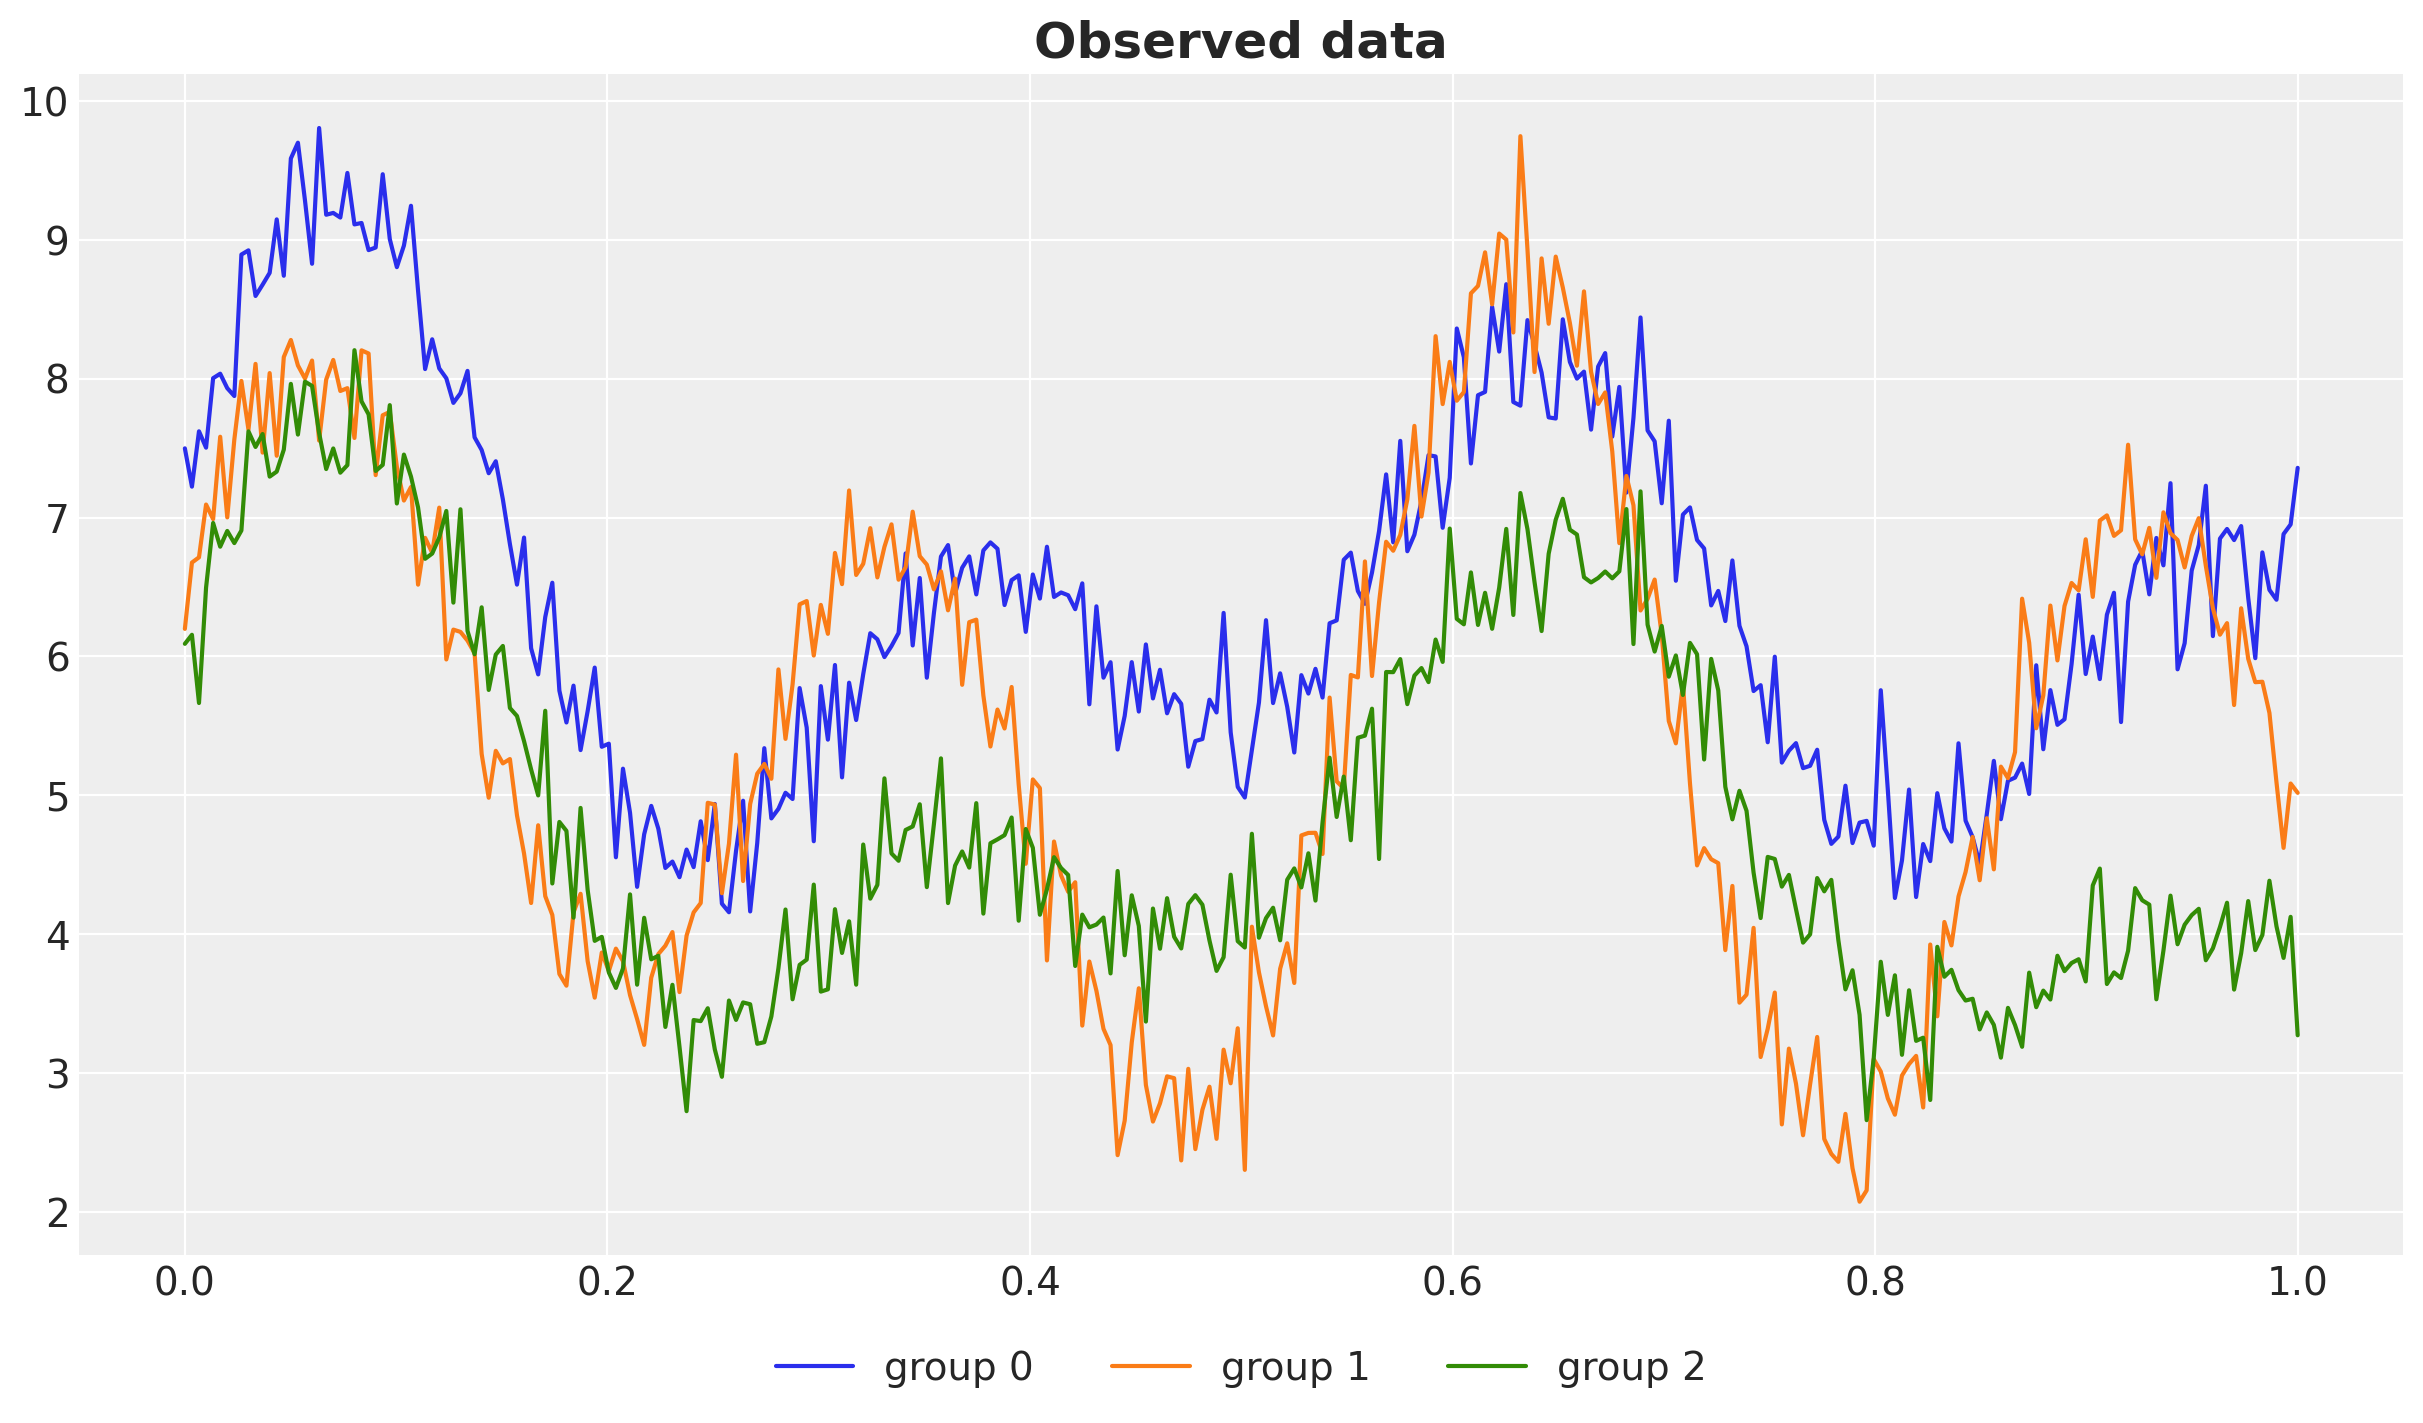

In [4]:
fig, ax = plt.subplots()

for g in range(n_groups):
    ax.plot(x, y[g], c=f"C{g}", label=f"group {g}")

ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=n_groups)
ax.set_title("Observed data", fontsize=18, fontweight="bold");

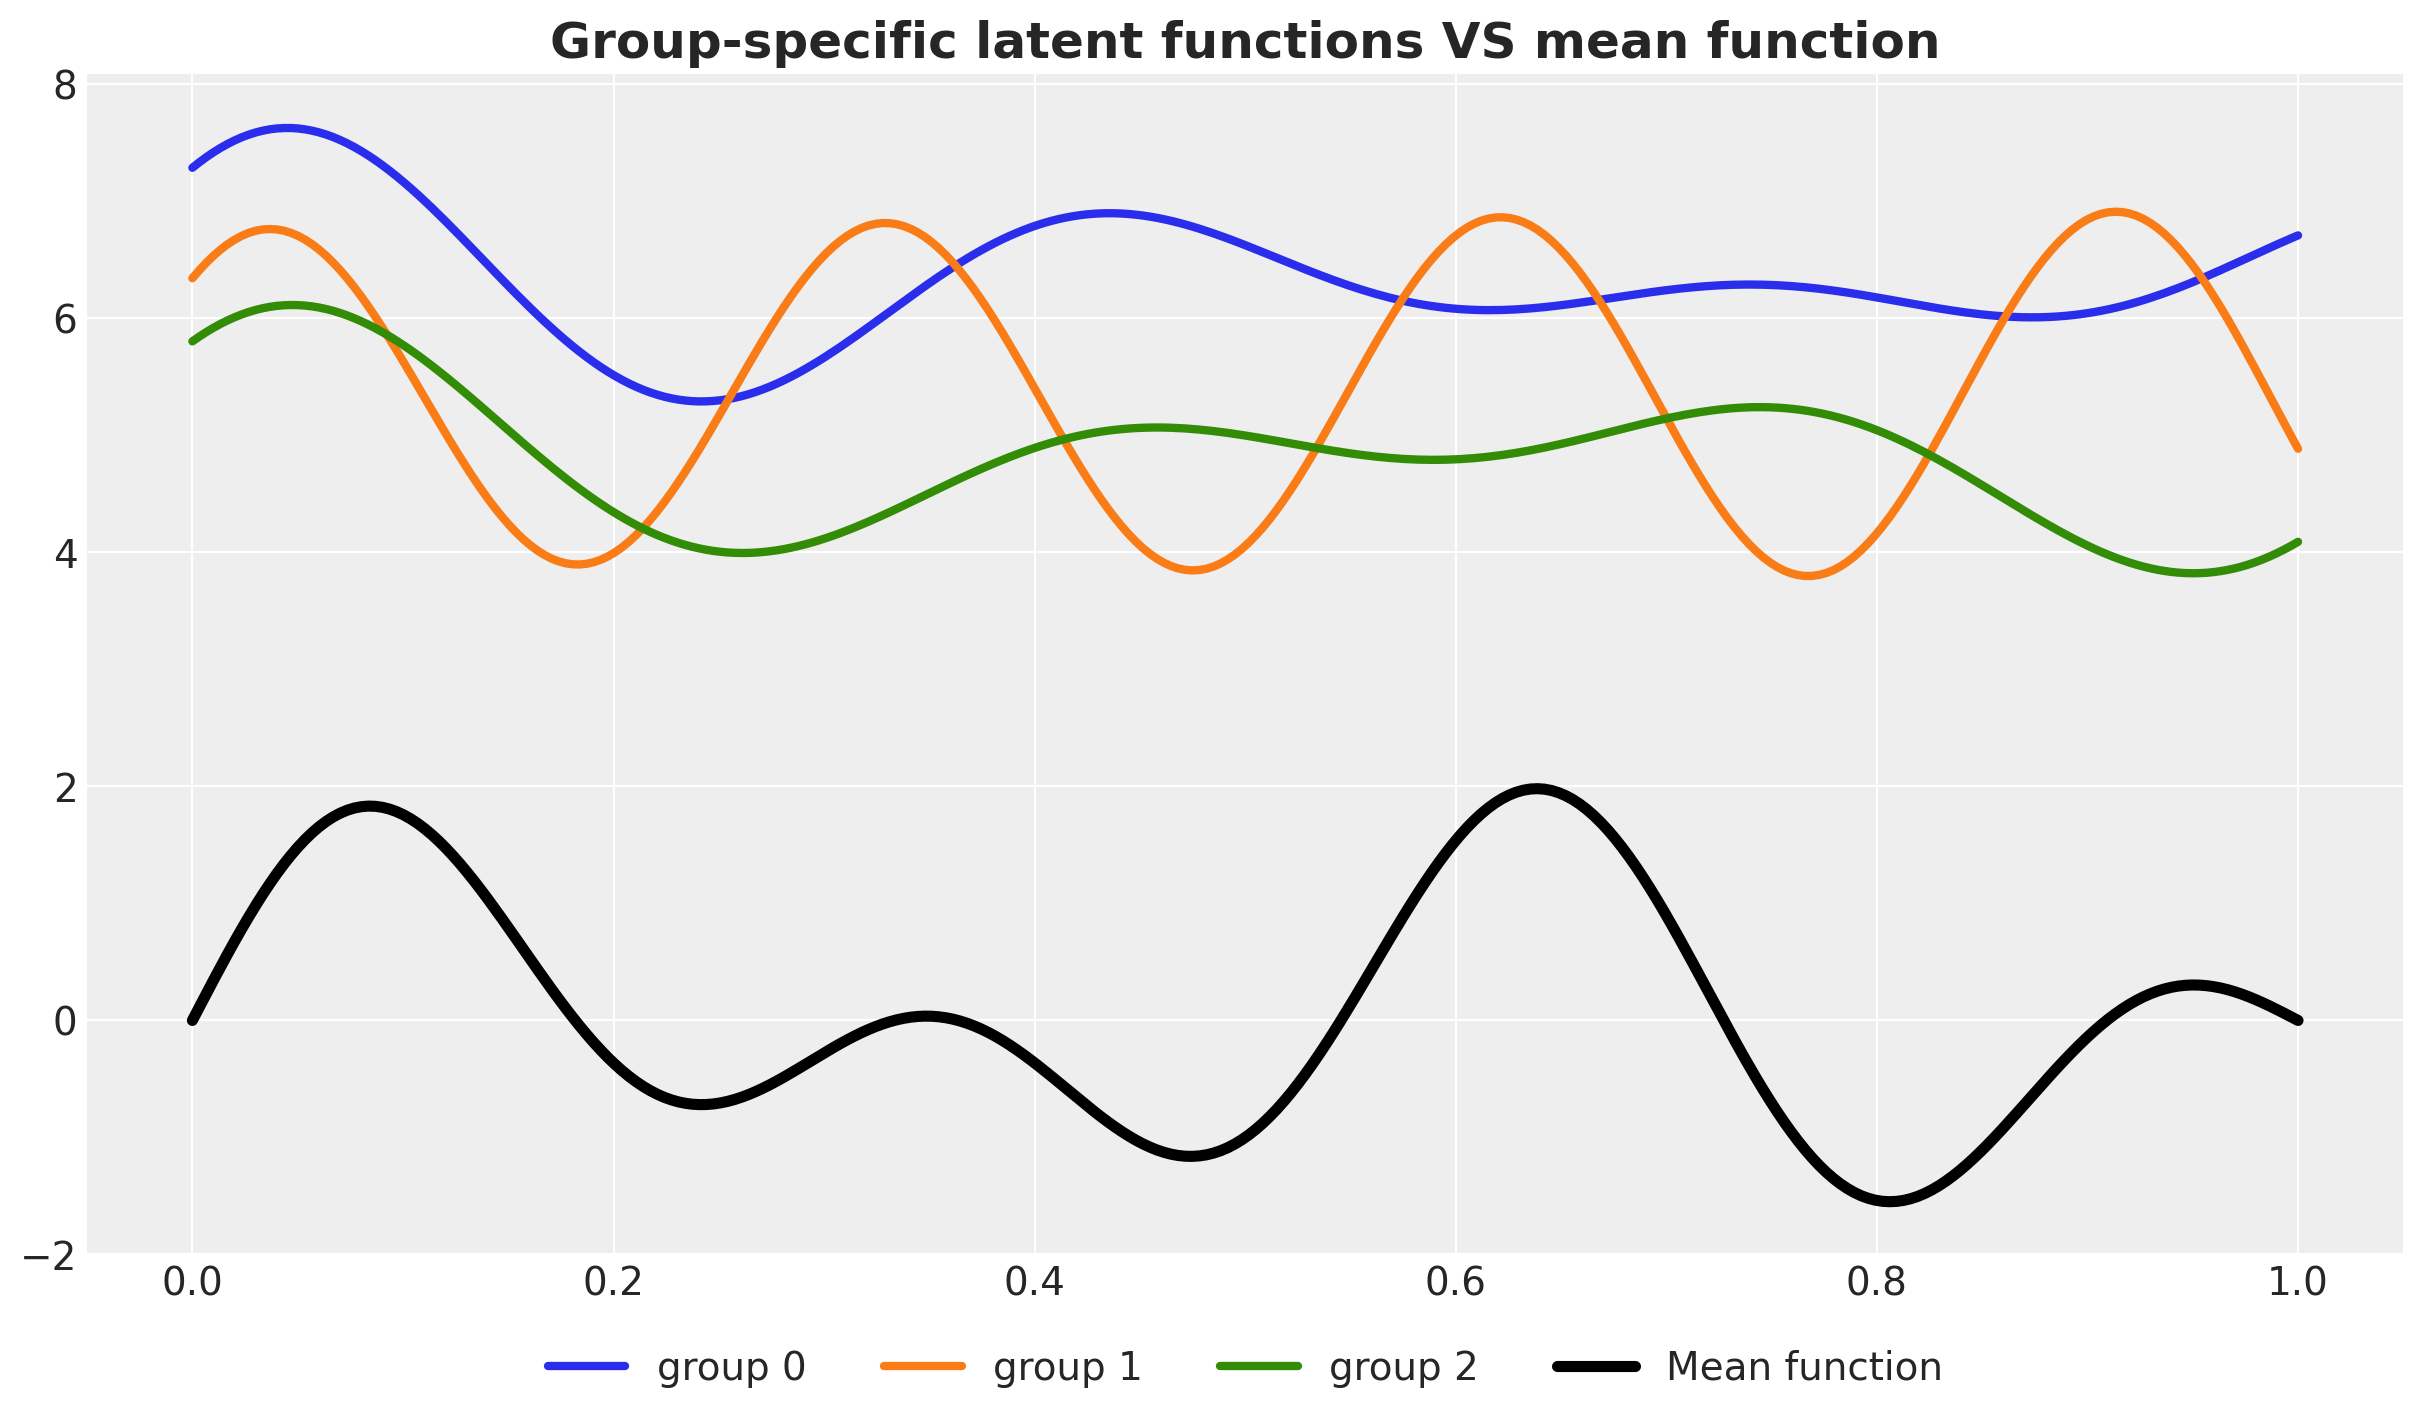

In [5]:
fig, ax = plt.subplots()

for g in range(n_groups):
    ax.plot(x, f_g[g], lw=3, c=f"C{g}", label=f"group {g}")

ax.plot(x, f[0], c="black", lw=4, label="Mean function")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=n_groups + 1)
ax.set_title(
    "Group-specific latent functions VS mean function", fontsize=18, fontweight="bold"
);

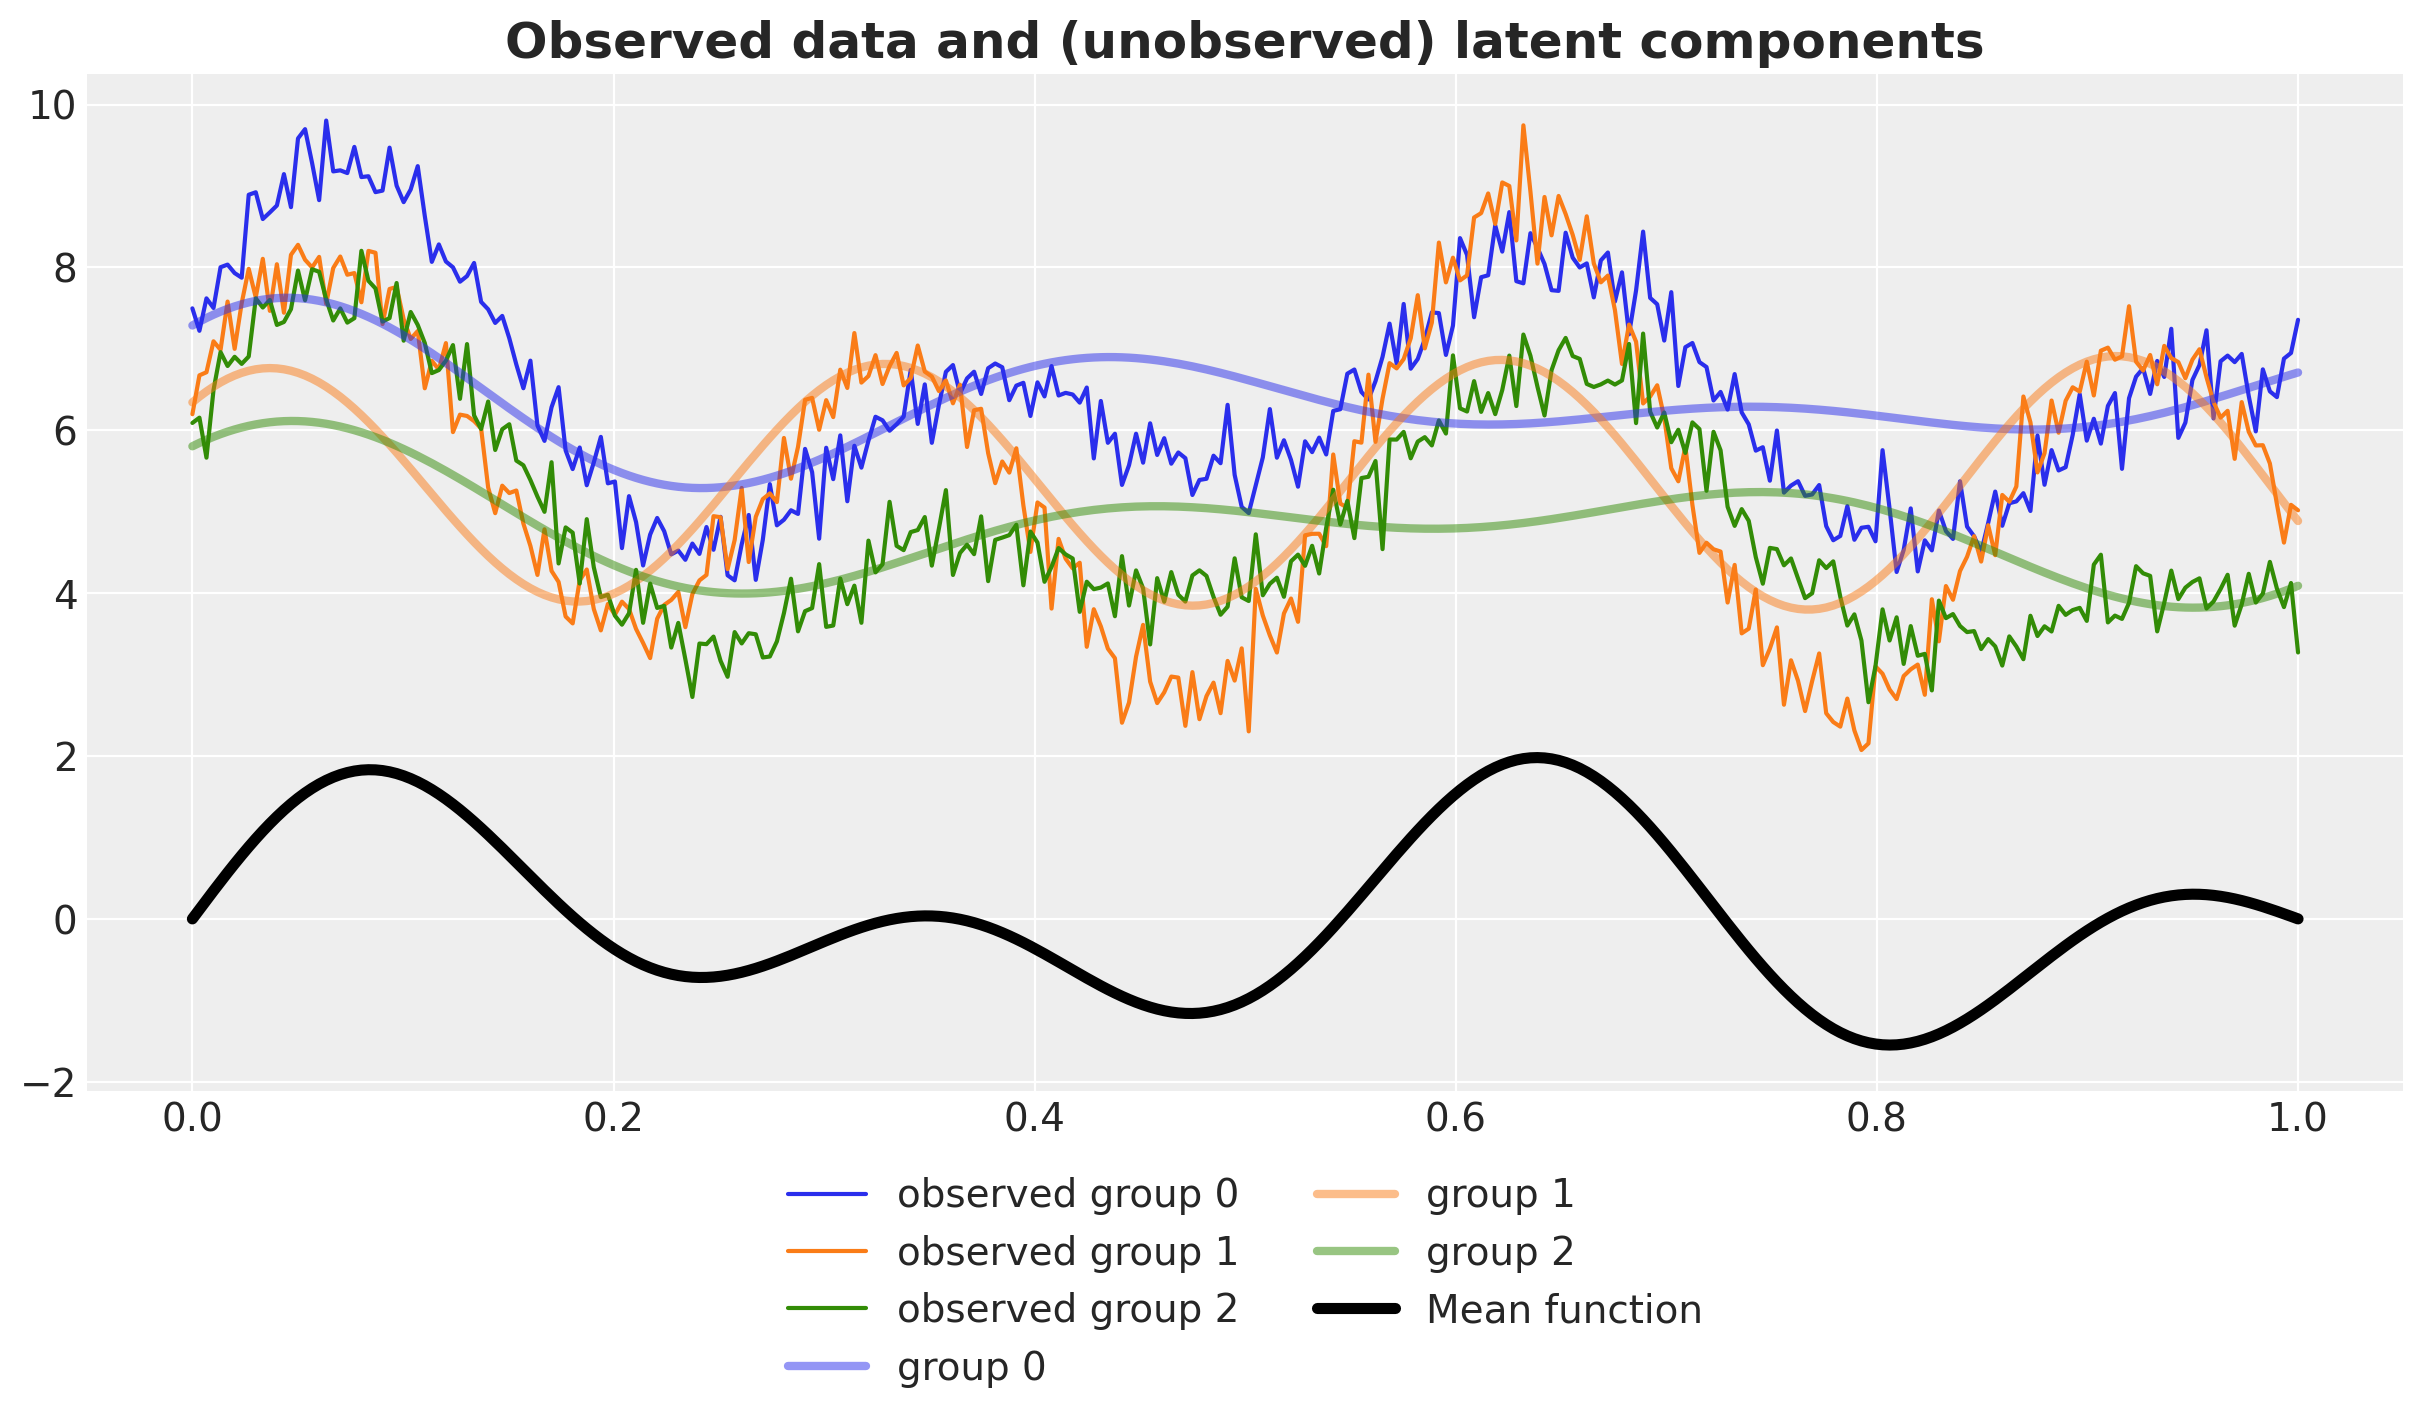

In [6]:
fig, ax = plt.subplots()

for g in range(n_groups):
    ax.plot(x, y[g], c=f"C{g}", label=f"observed group {g}")

for g in range(n_groups):
    ax.plot(x, f_g[g], lw=3, c=f"C{g}", alpha=0.5, label=f"group {g}")

ax.plot(x, f[0], c="black", lw=4, label="Mean function")
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=n_groups - 1)
ax.set_title(
    "Observed data and (unobserved) latent components", fontsize=18, fontweight="bold"
);

## Train Test Split

In [7]:
n_train = 260

x_train = x[:n_train]
x_test = x[n_train:]

y_train = y[:, :n_train]
y_test = y[:, n_train:]

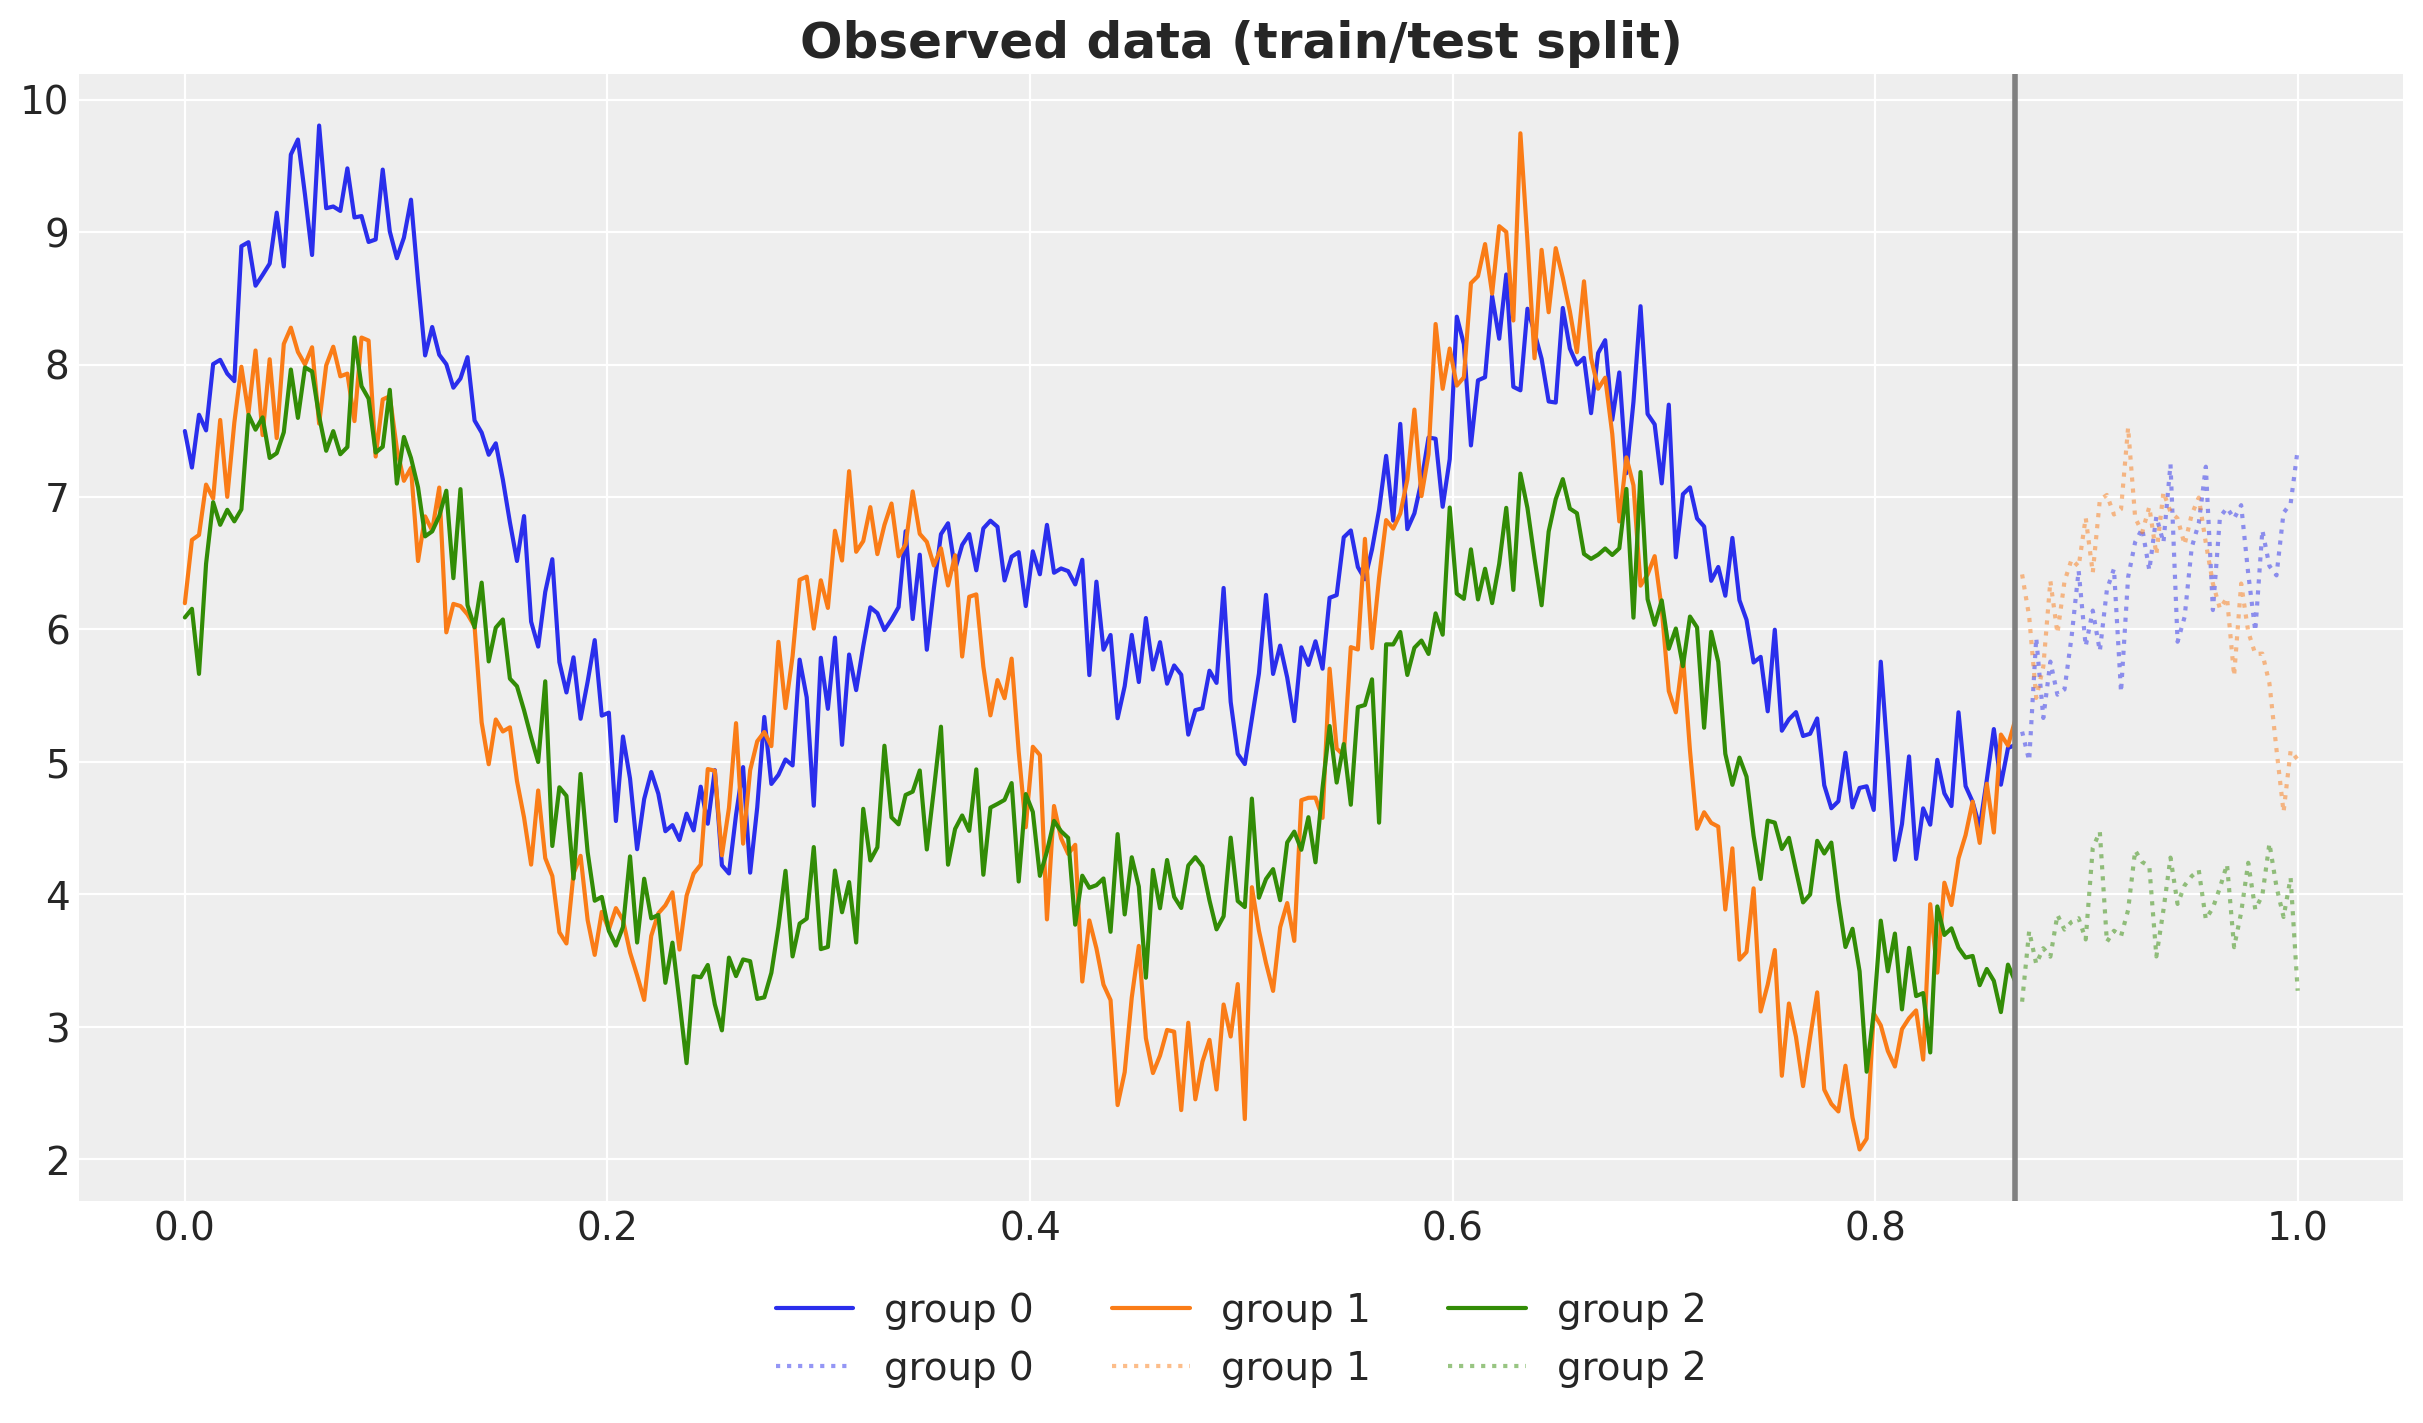

In [8]:
fig, ax = plt.subplots()

for g in range(n_groups):
    ax.plot(x_train, y_train[g], c=f"C{g}", label=f"group {g}")
    ax.plot(x_test, y_test[g], c=f"C{g}", ls="dotted", alpha=0.5, label=f"group {g}")

ax.axvline(x=x_train[-1], c="gray", lw=2)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=n_groups)
ax.set_title("Observed data (train/test split)", fontsize=18, fontweight="bold");

## Model Specification

In [9]:
def diag_spectral_density_squared_exponential_vectorized(alpha, length, ell, m, dim):
    theta = jnp.stack([alpha, length], axis=0)
    return vmap(
        lambda theta: diag_spectral_density_squared_exponential(
            alpha=theta[0],  # alpha,
            length=theta[1],  # length,
            ell=ell,
            m=m,
            dim=dim,
        ),
        in_axes=-1,
    )(theta)

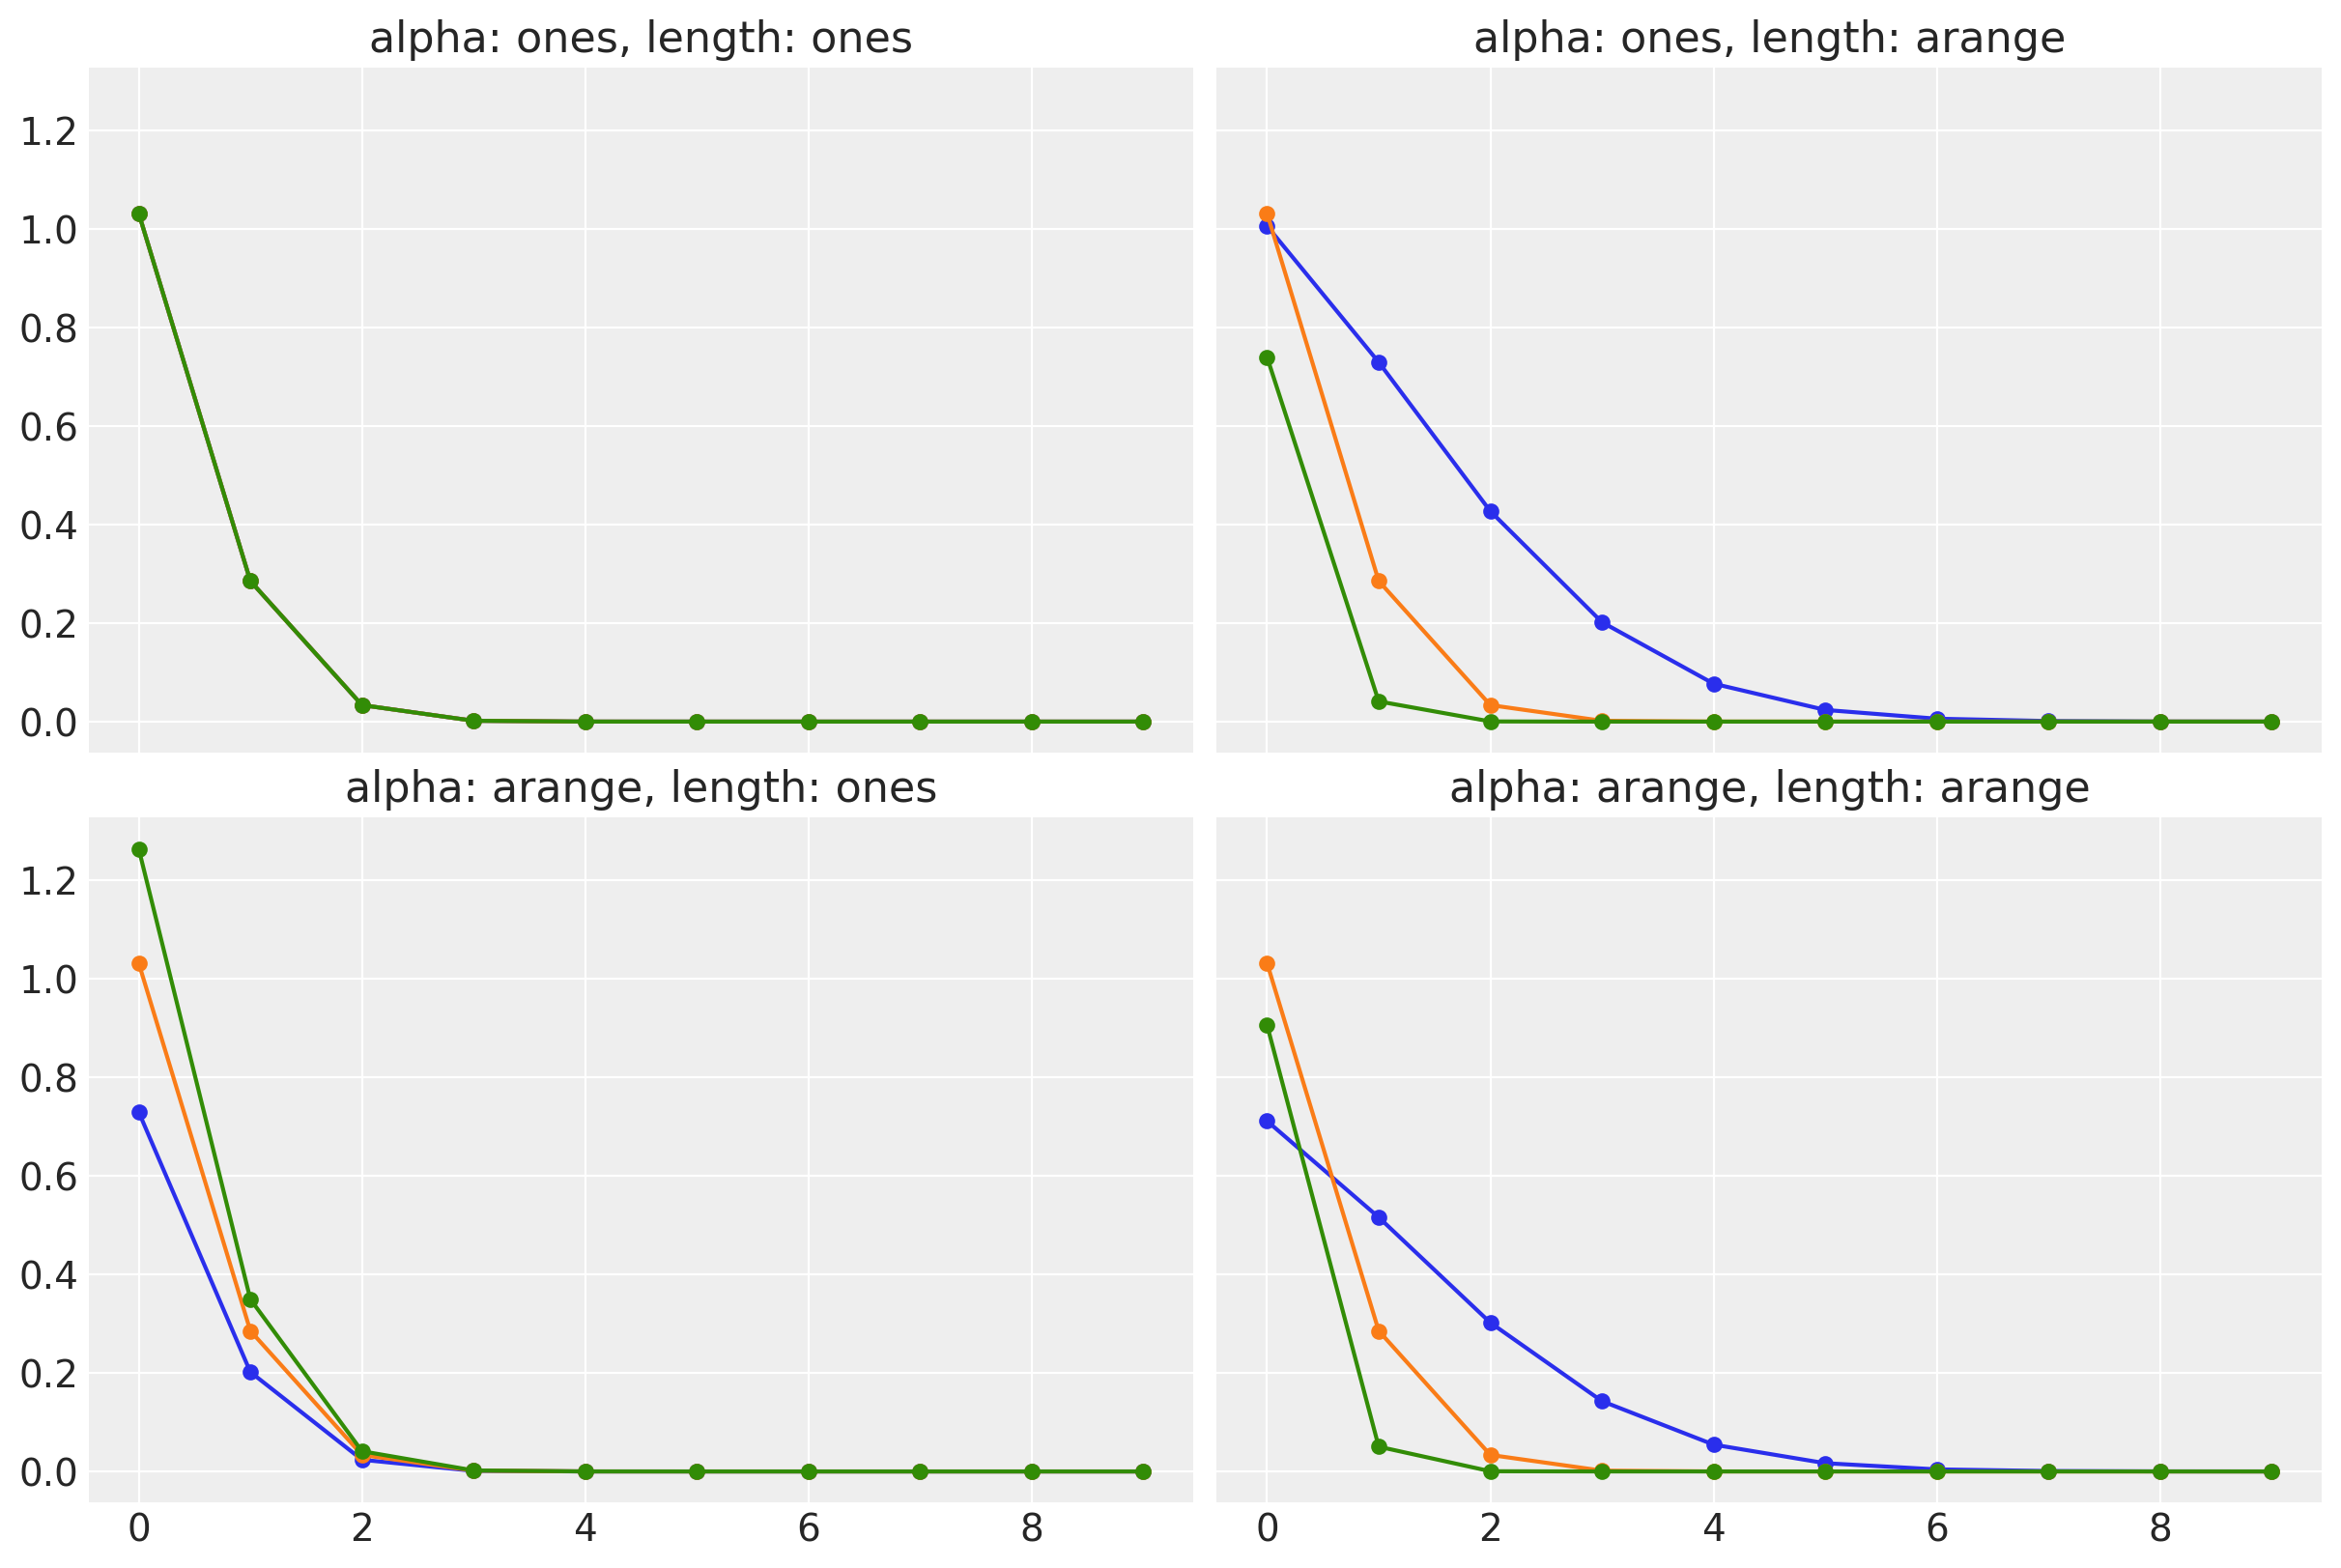

In [10]:
ell = 1.2
m = 10
dim = 1

ones_array = jnp.ones(n_groups)
arange_array = 0.5 * jnp.arange(start=1, stop=n_groups + 1, step=1)


fig, axes = plt.subplots(
    nrows=2, ncols=2, figsize=(12, 8), sharex=True, sharey=True, layout="constrained"
)

for i, alpha in enumerate([ones_array, arange_array]):
    for j, length in enumerate([ones_array, arange_array]):
        spd = jnp.sqrt(
            diag_spectral_density_squared_exponential_vectorized(
                alpha=alpha,
                length=length,
                ell=ell,
                m=m,
                dim=dim,
            )
        )

        assert spd.shape == (n_groups, m)

        ax = axes[i, j]

        alpha_label = "ones" if i == 0 else "arange"
        length_label = "ones" if j == 0 else "arange"

        for g in range(n_groups):
            ax.plot(spd[g], c=f"C{g}", marker="o", markersize=5, label=f"group {g}")

        ax.set_title(f"alpha: {alpha_label}, length: {length_label}")

In [11]:
spd = jnp.sqrt(
    diag_spectral_density_squared_exponential_vectorized(
        alpha=arange_array,
        length=arange_array,
        ell=ell,
        m=m,
        dim=dim,
    )
)

for i, (single_alpha, single_length) in enumerate(
    zip(arange_array, arange_array, strict=True)
):
    assert jnp.array_equal(
        spd[i],
        jnp.sqrt(
            diag_spectral_density_squared_exponential(
                alpha=single_alpha, length=single_length, ell=ell, m=m, dim=dim
            )
        ),
    )

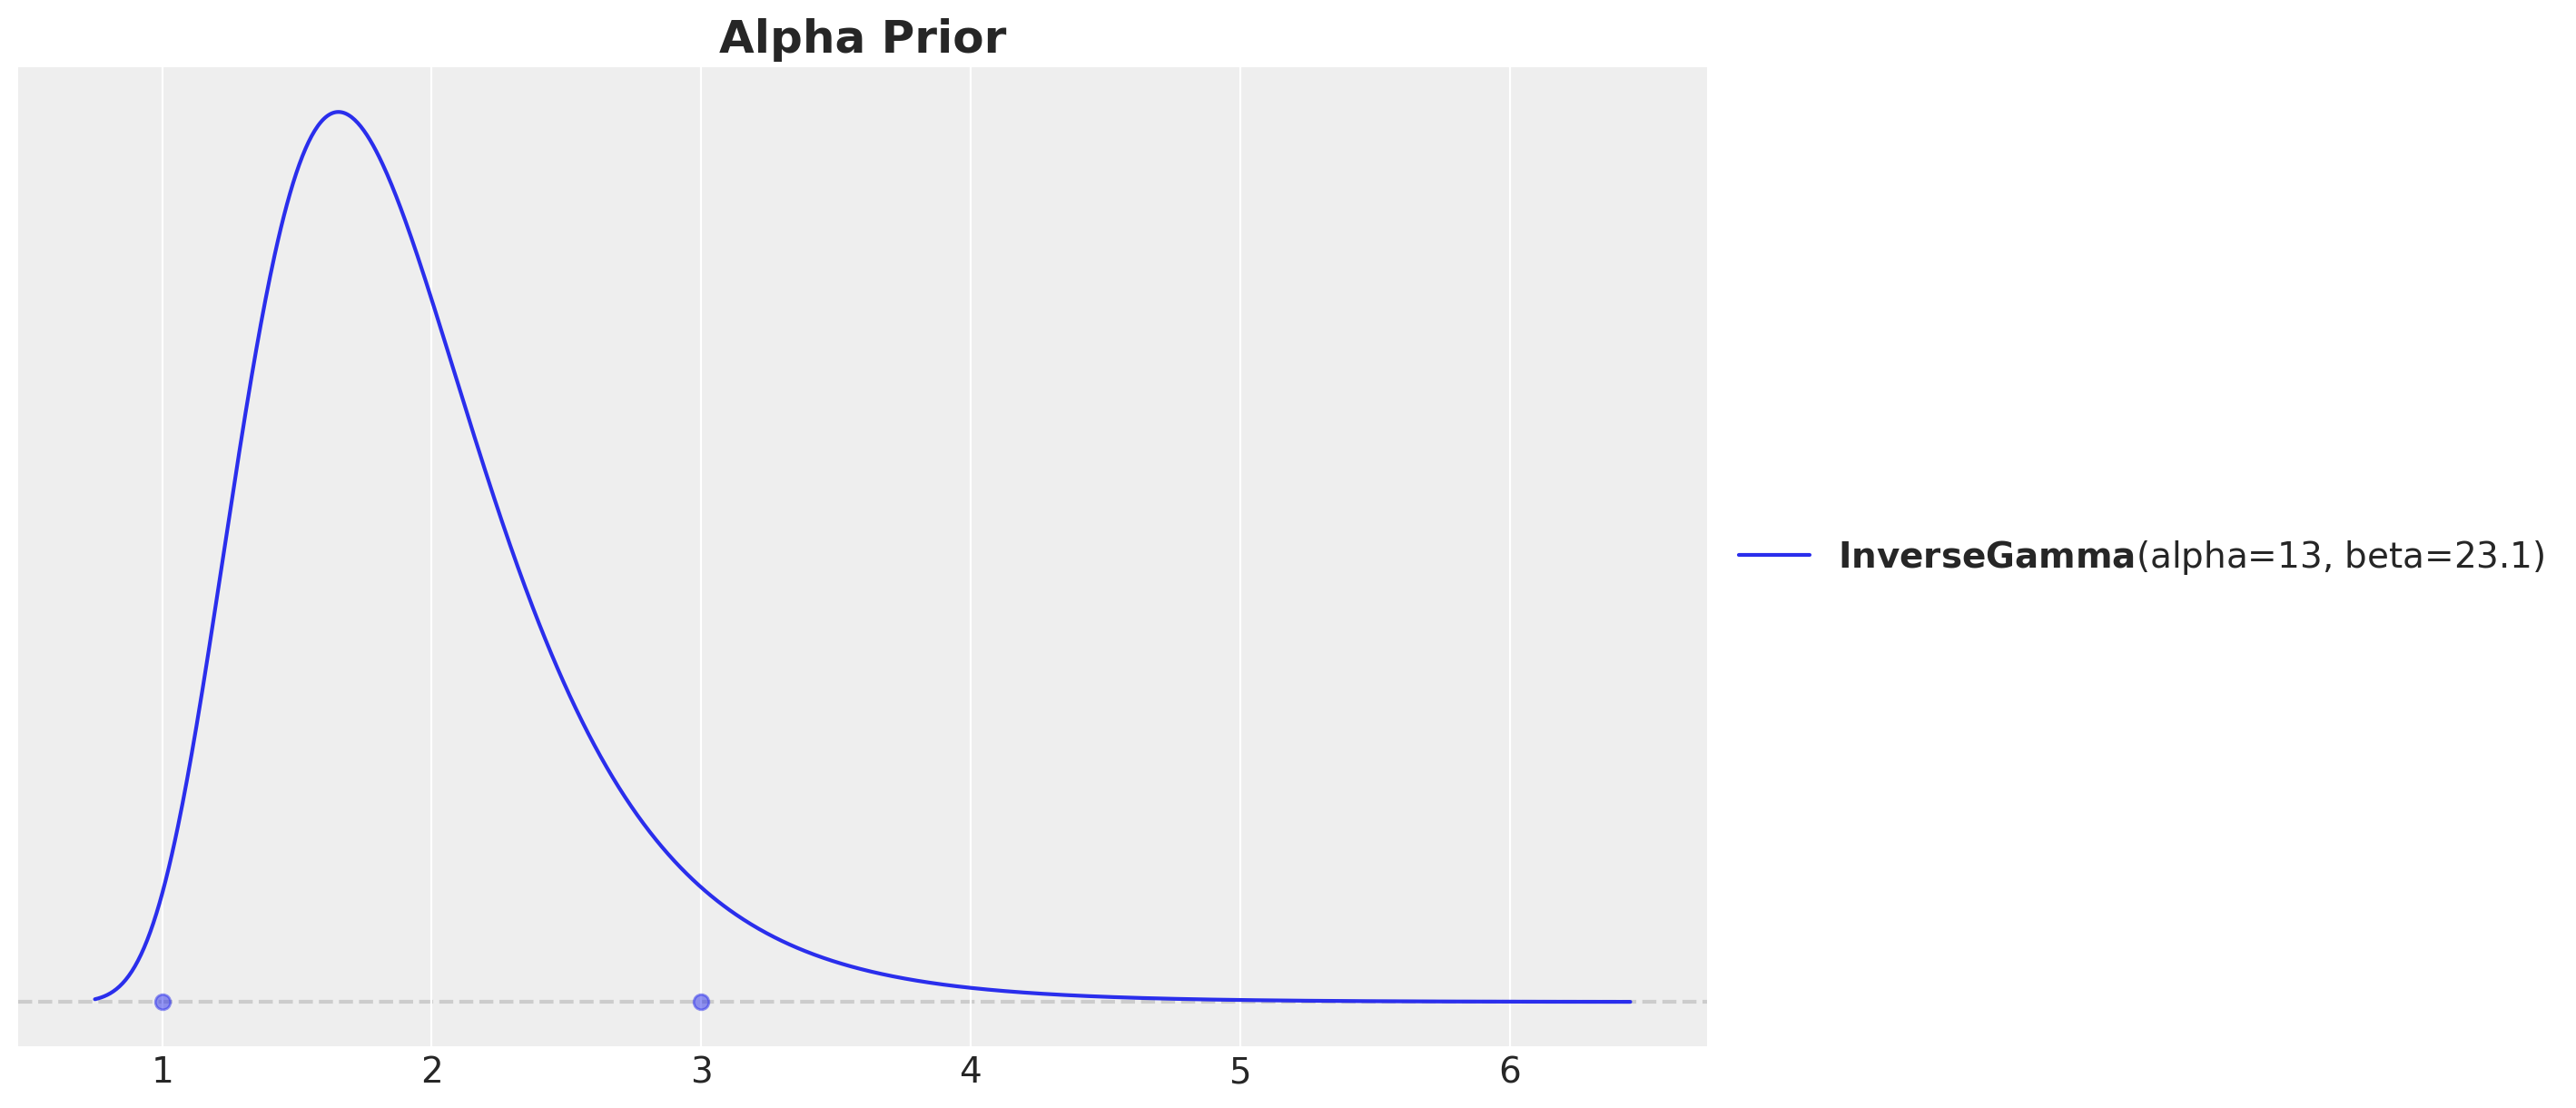

In [12]:
alpha_prior, ax = pz.maxent(pz.InverseGamma(), lower=1, upper=3, mass=0.94)
ax.set_title("Alpha Prior", fontsize=18, fontweight="bold");

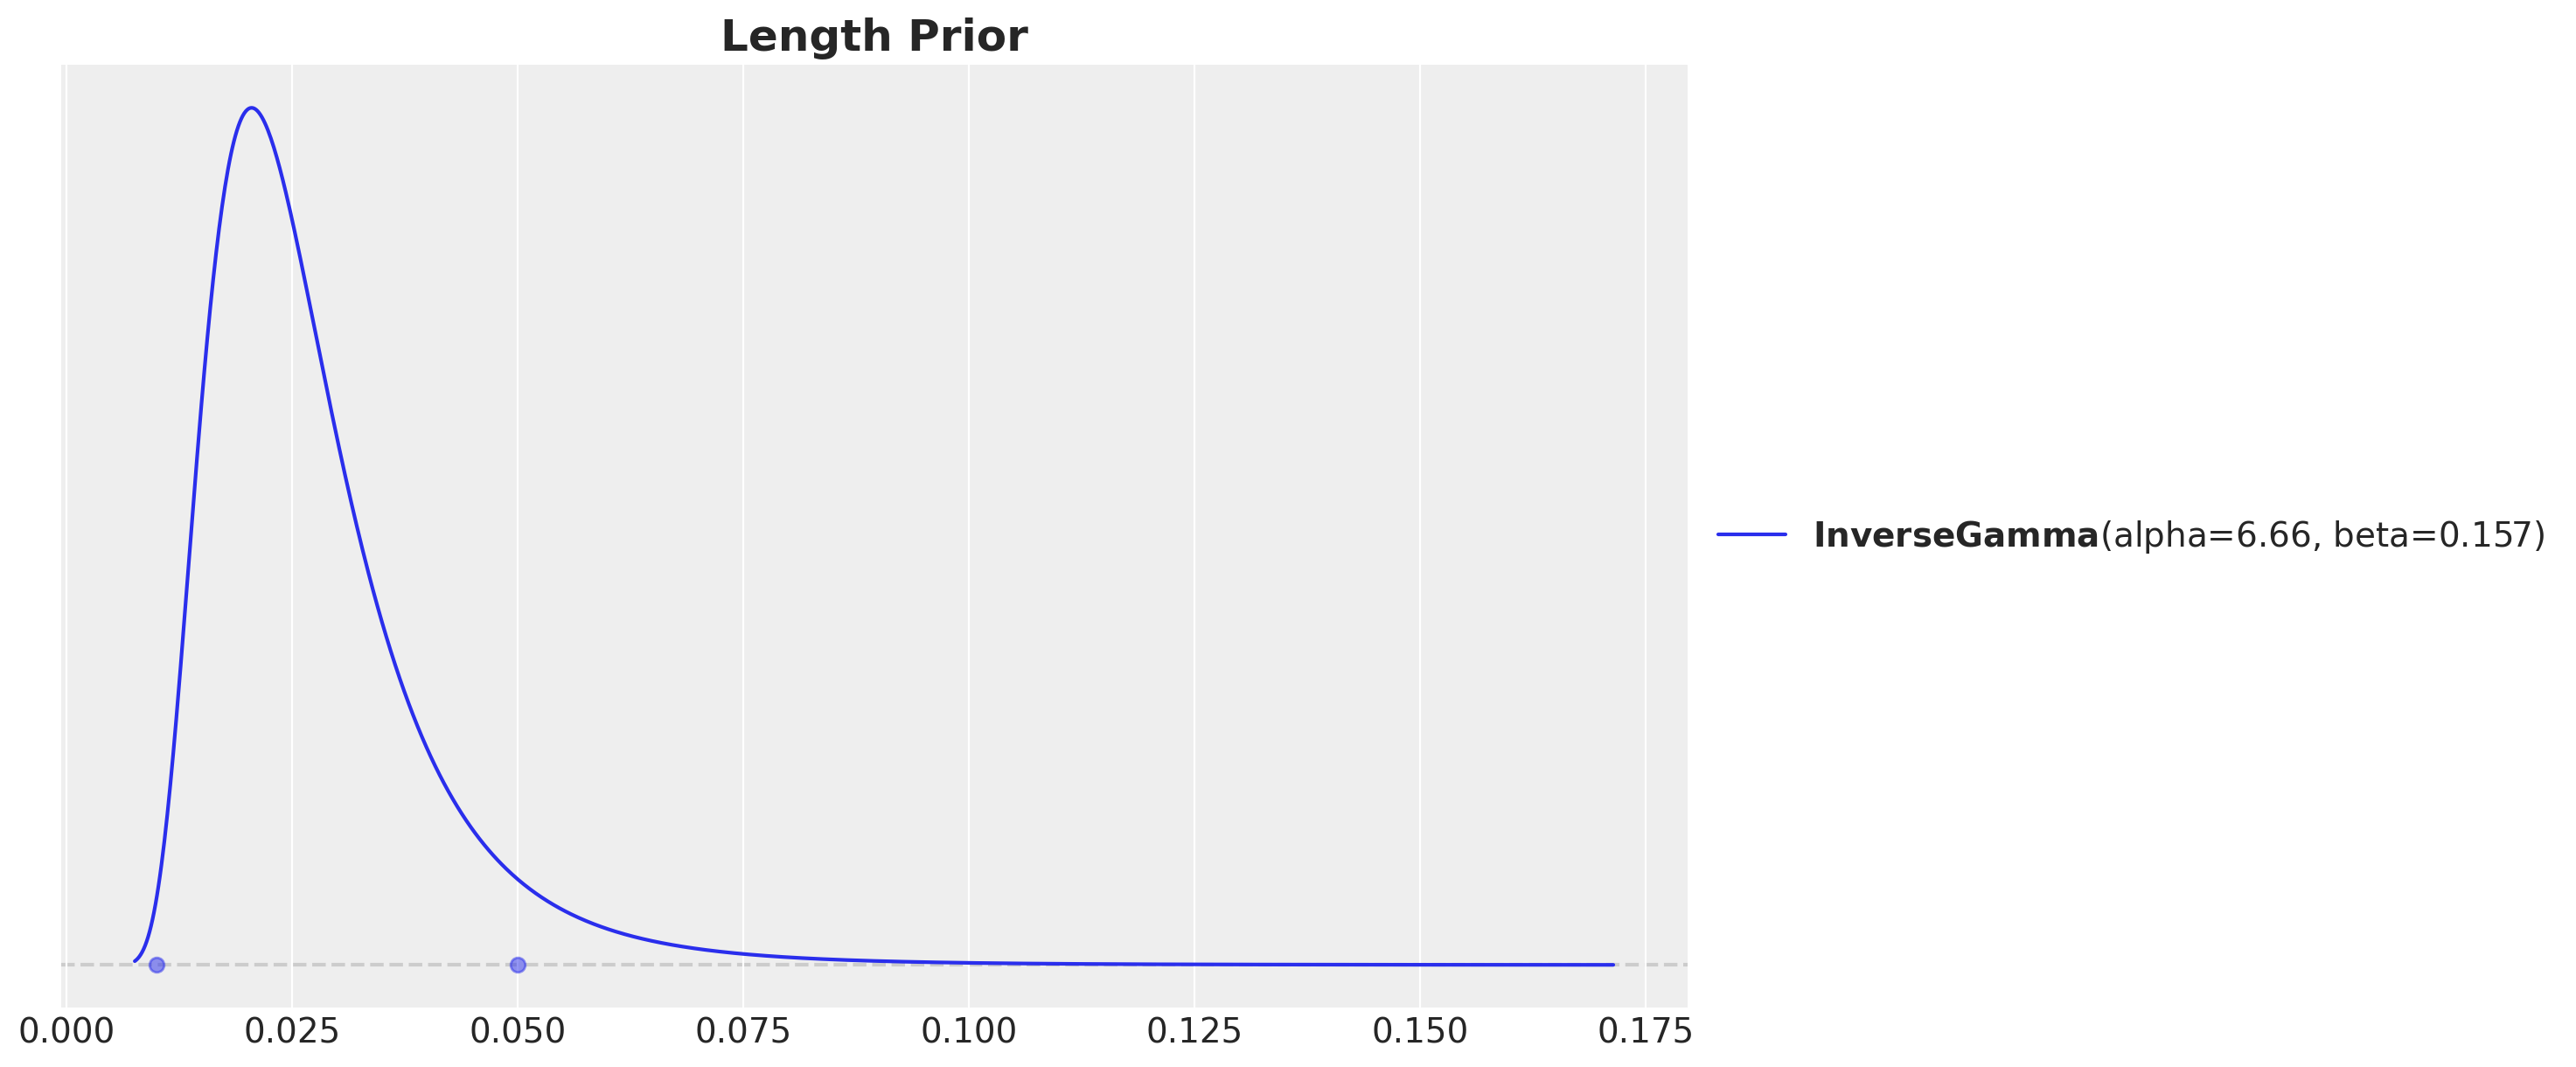

In [13]:
length_prior, ax = pz.maxent(pz.InverseGamma(), lower=0.01, upper=0.05, mass=0.94)
ax.set_title("Length Prior", fontsize=18, fontweight="bold");

In [28]:
def global_hsgp(x, ell, m):
    alpha_global = numpyro.sample(
        "alpha_global", dist.InverseGamma(concentration=13, rate=23)
    )
    length_global = numpyro.sample(
        "length_global", dist.InverseGamma(concentration=7, rate=0.15)
    )

    return numpyro.deterministic(
        "f_global",
        hsgp_squared_exponential(
            x=x,
            alpha=alpha_global,
            length=length_global,
            ell=ell,
            m=m,
            non_centered=True,
        ),
    )


def group_deltas_hsgp(y, x, ell, m):
    n_groups, _ = y.shape

    numpyro.plate("groups", n_groups, dim=-1)

    with numpyro.plate("groups", n_groups, dim=-1):
        alpha_groups = numpyro.sample(
            "alpha_groups", dist.InverseGamma(concentration=13, rate=23)
        )
        length_groups = numpyro.sample(
            "length_groups", dist.InverseGamma(concentration=7, rate=0.15)
        )

        group_intercepts = numpyro.sample(
            "group_intercepts", dist.Normal(loc=5, scale=2)
        )

    phi = eigenfunctions(x=x, ell=ell, m=m)

    spd = jnp.sqrt(
        diag_spectral_density_squared_exponential_vectorized(
            alpha=alpha_groups, length=length_groups, ell=ell, m=m, dim=dim
        )
    )

    with numpyro.plate("groups", n_groups, dim=-1), numpyro.plate("basis", m, dim=-2):
        beta_delta = numpyro.sample("beta_delta", dist.Normal(loc=0.0, scale=1.0))

    return numpyro.deterministic(
        "f_delta", (phi @ (spd.T * beta_delta)).T + group_intercepts[..., None]
    )


def model(x, y, ell, m) -> None:
    n_groups, n_obs = y.shape

    scale = numpyro.sample("scale", dist.HalfNormal(scale=1))

    f_global = global_hsgp(x, ell, m)

    f_delta = group_deltas_hsgp(y, x, ell, m)

    f_group = numpyro.deterministic("f_group", f_global + f_delta)

    numpyro.sample("obs", dist.Normal(loc=f_group, scale=scale))

In [29]:
n_groups, n_obs = y.shape

n_obs

300

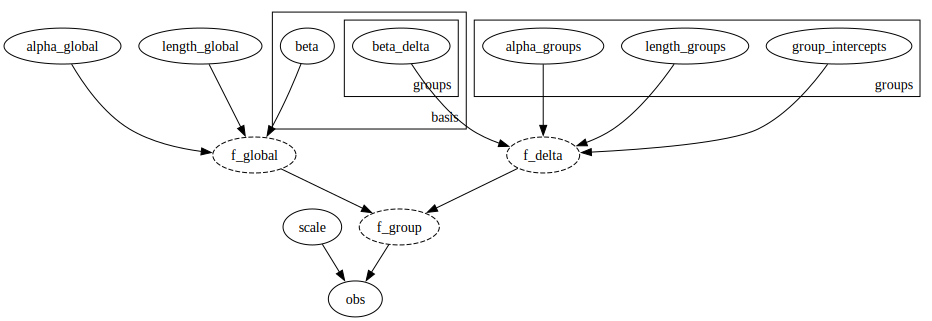

In [52]:
ell = 1.2
m = 25

numpyro.render_model(model, model_args=(x_train, y_train, 1.5, 10))

In [53]:
prior_predictive = Predictive(model, num_samples=100, return_sites=["obs"])


rng_key, rng_subkey = random.split(rng_key)
prior_predictive_samples = prior_predictive(rng_subkey, x_train, y_train, ell, m)

prior_predictive_idata = az.from_numpyro(
    prior=prior_predictive_samples,
    coords={"x": x_train, "group": jnp.arange(n_groups)},
    dims={"f": ["group", "x"], "obs": ["group", "x"]},
)

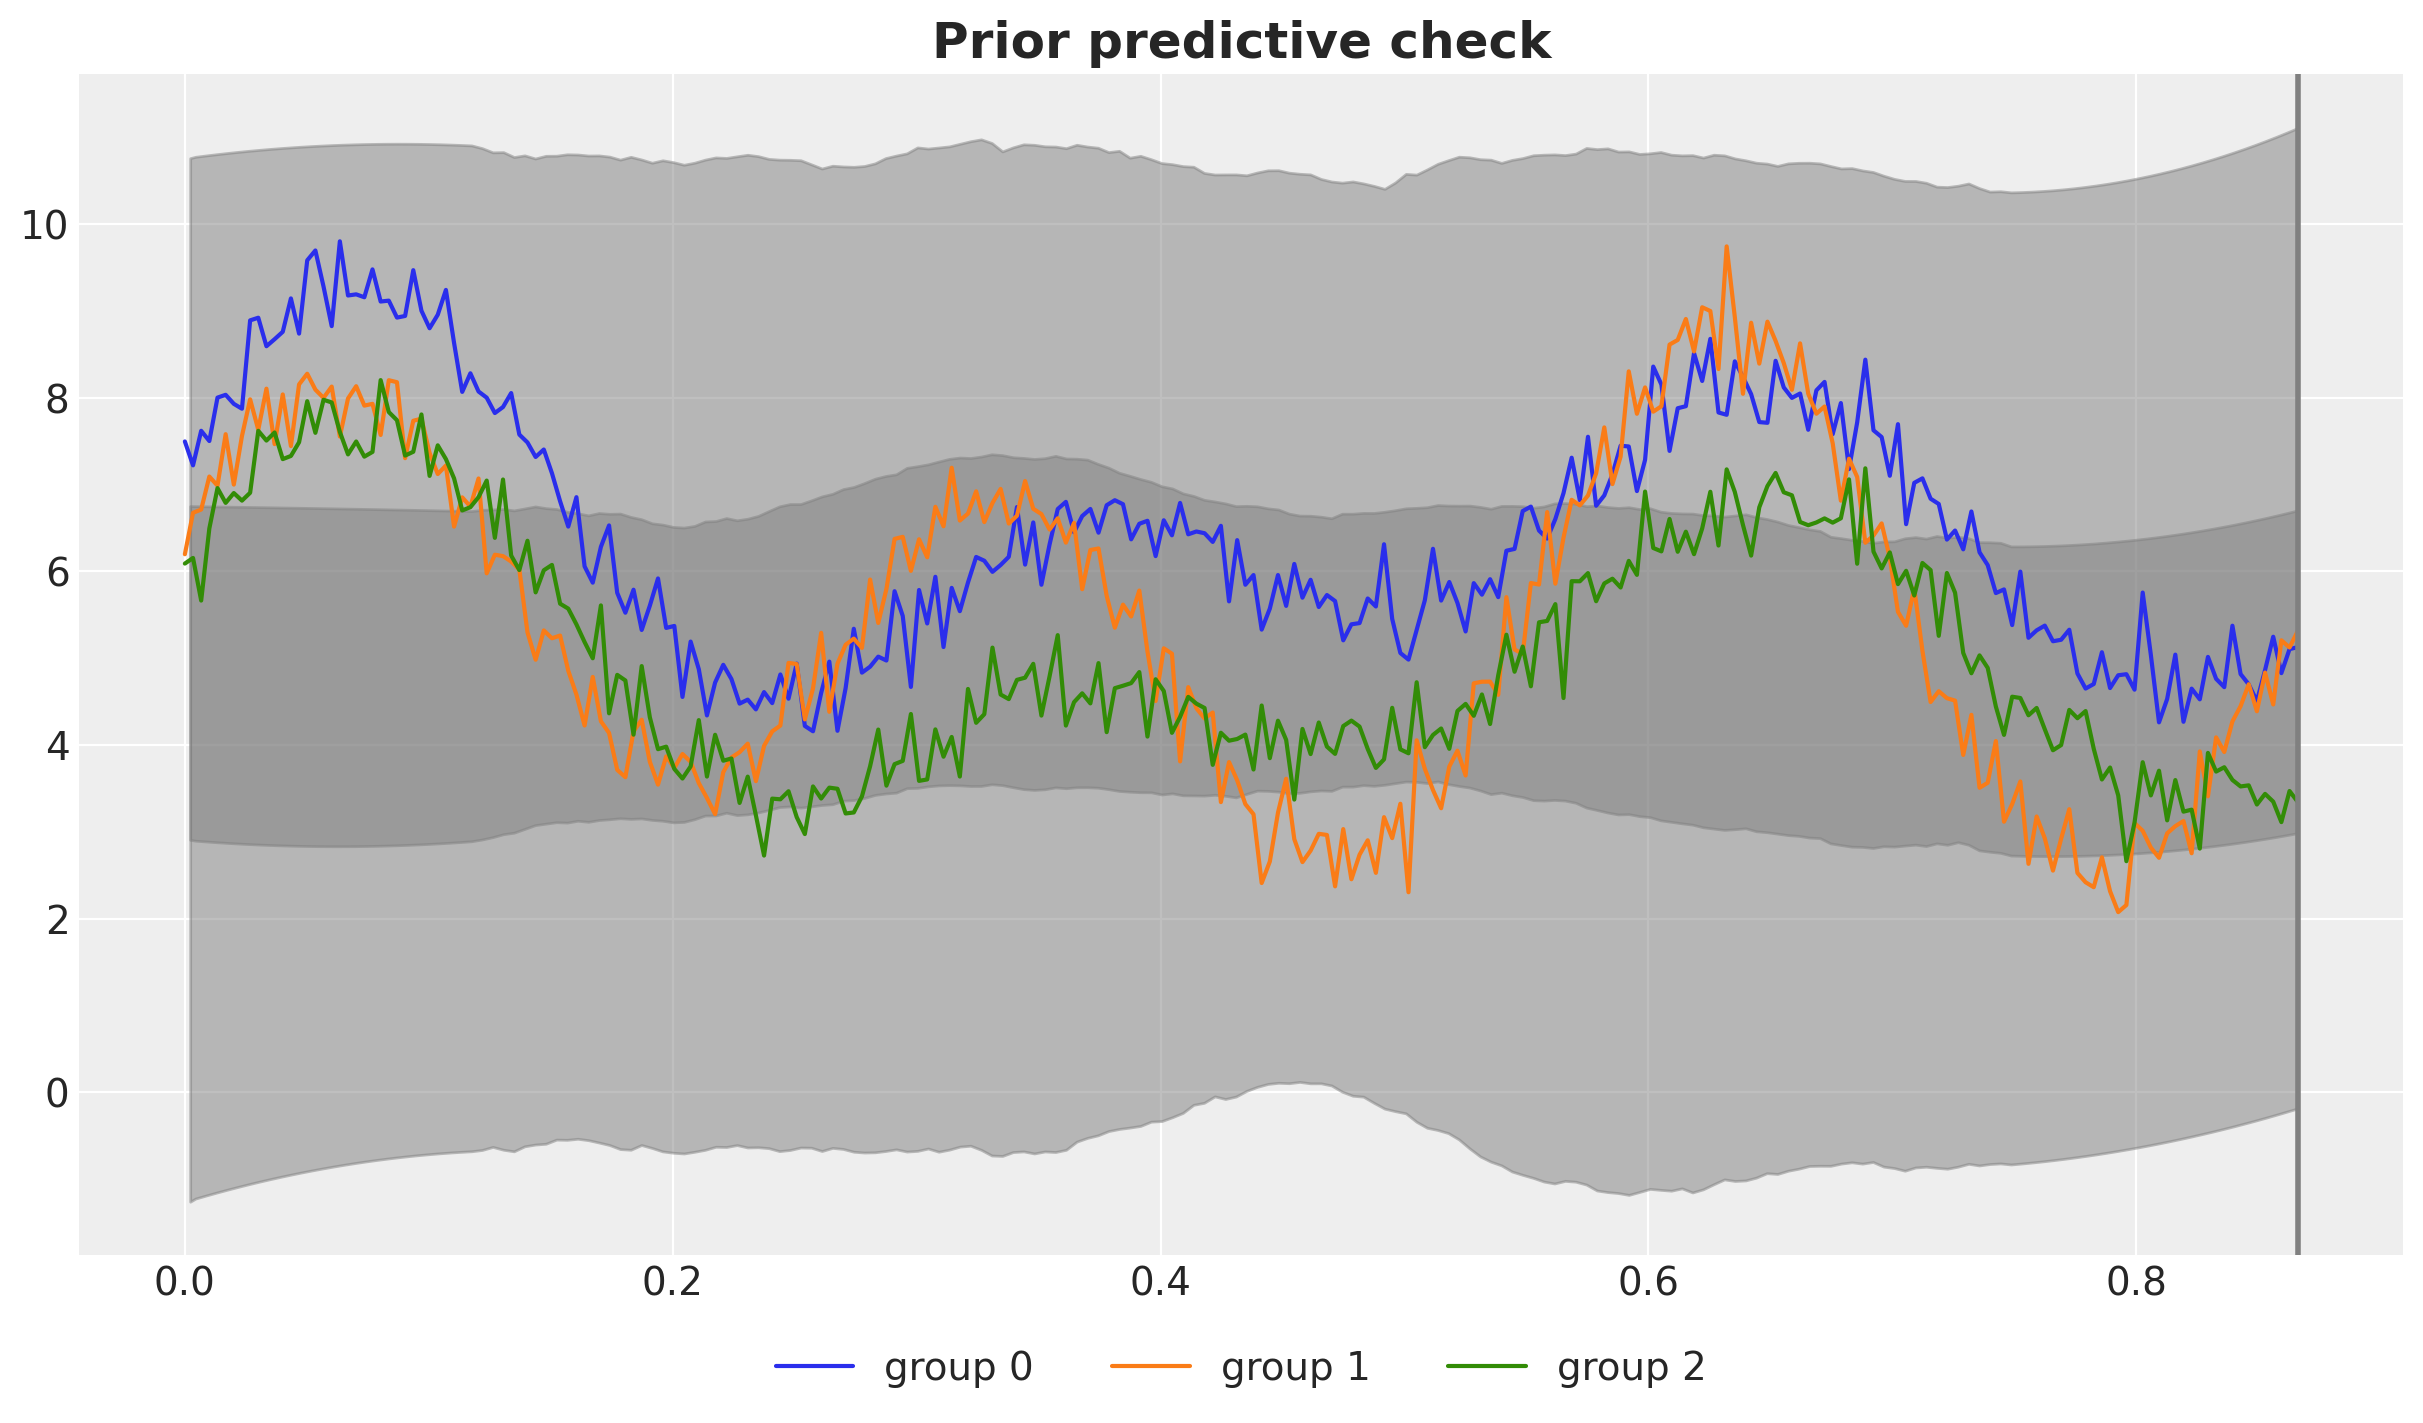

In [54]:
fig, ax = plt.subplots()

for hdi_prob in [0.5, 0.94]:
    az.plot_hdi(
        x_train,
        prior_predictive_idata["prior"]["obs"].sel(group=0),
        fill_kwargs={"color": "gray"},
        ax=ax,
        hdi_prob=hdi_prob,
    )

for g in range(n_groups):
    ax.plot(x_train, y_train[g], c=f"C{g}", label=f"group {g}")

ax.axvline(x=x_train[-1], c="gray", lw=2)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=n_groups)
ax.set_title("Prior predictive check", fontsize=18, fontweight="bold");

In [55]:
conditioned_model = condition(model, data={"obs": y_train})

sampler = NUTS(conditioned_model, target_accept_prob=0.95)

mcmc = MCMC(sampler, num_warmup=1_000, num_samples=1_000, num_chains=4)

rng_key, rng_subkey = random.split(rng_key)
mcmc.run(rng_subkey, x_train, y_train, ell, m)

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [56]:
idata = az.from_numpyro(
    posterior=mcmc,
    coords={"x": x_train, "group": jnp.arange(n_groups), "m": jnp.arange(m)},
    dims={
        "alpha_groups": ["group"],
        "length_groups": ["group"],
        "beta": ["m"],
        "beta_delta": ["m", "group"],
        "group_intercepts": ["group"],
        "f_delta": ["group", "x"],
        "f_global": ["x"],
        "f_group": ["group", "x"],
        "obs": ["group", "x"],
    },
)

In [57]:
idata["sample_stats"].diverging.sum().item()

2000

In [58]:
az.summary(
    idata,
    var_names=[
        "alpha_global",
        "length_global",
        "alpha_groups",
        "length_groups",
        "group_intercepts",
        "scale",
    ],
)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
alpha_global         1.611  0.934   0.163    2.829      0.422    0.318   
length_global        0.555  0.560   0.019    1.358      0.279    0.213   
alpha_groups[0]      0.929  0.687   0.248    2.000      0.316    0.239   
alpha_groups[1]      3.973  2.090   1.400    6.505      1.027    0.793   
alpha_groups[2]      1.083  0.601   0.310    2.036      0.265    0.199   
length_groups[0]     0.182  0.164   0.012    0.372      0.082    0.063   
length_groups[1]     0.224  0.217   0.016    0.546      0.108    0.083   
length_groups[2]     0.896  1.447   0.012    3.400      0.721    0.552   
group_intercepts[0]  2.743  3.402  -0.933    6.651      1.687    1.291   
group_intercepts[1]  2.820  2.515  -0.387    5.808      1.241    0.949   
group_intercepts[2]  2.195  2.616  -1.160    5.242      1.293    0.989   
scale                0.372  0.171   0.219    0.661      0.085    0.065   

                     ess_bulk  ess_tail  r_hat  
alpha_global              7.0       4.0   2.62  
length_global             5.0     146.0   3.40  
alpha_groups[0]           5.0       4.0   2.29  
alpha_groups[1]           5.0     138.0   2.29  
alpha_groups[2]           5.0       4.0   2.25  
length_groups[0]          5.0     141.0   2.29  
length_groups[1]          5.0     137.0   3.40  
length_groups[2]          5.0     136.0   3.40  
group_intercepts[0]       5.0       4.0   2.29  
group_intercepts[1]       5.0       4.0   2.29  
group_intercepts[2]       5.0       4.0   2.29  
scale                     4.0       4.0   3.41

In [59]:
posterior_predictive = Predictive(
    model, posterior_samples=mcmc.get_samples(), return_sites=["obs"]
)

rng_key, rng_subkey = random.split(rng_key)
posterior_predictive_samples = posterior_predictive(
    rng_subkey, x_train, y_train, ell, m
)

idata.extend(
    az.from_numpyro(
        posterior_predictive=posterior_predictive_samples,
        coords={"x": x_train, "group": jnp.arange(n_groups)},
        dims={"f_group": ["group", "x"], "obs": ["group", "x"]},
    )
)

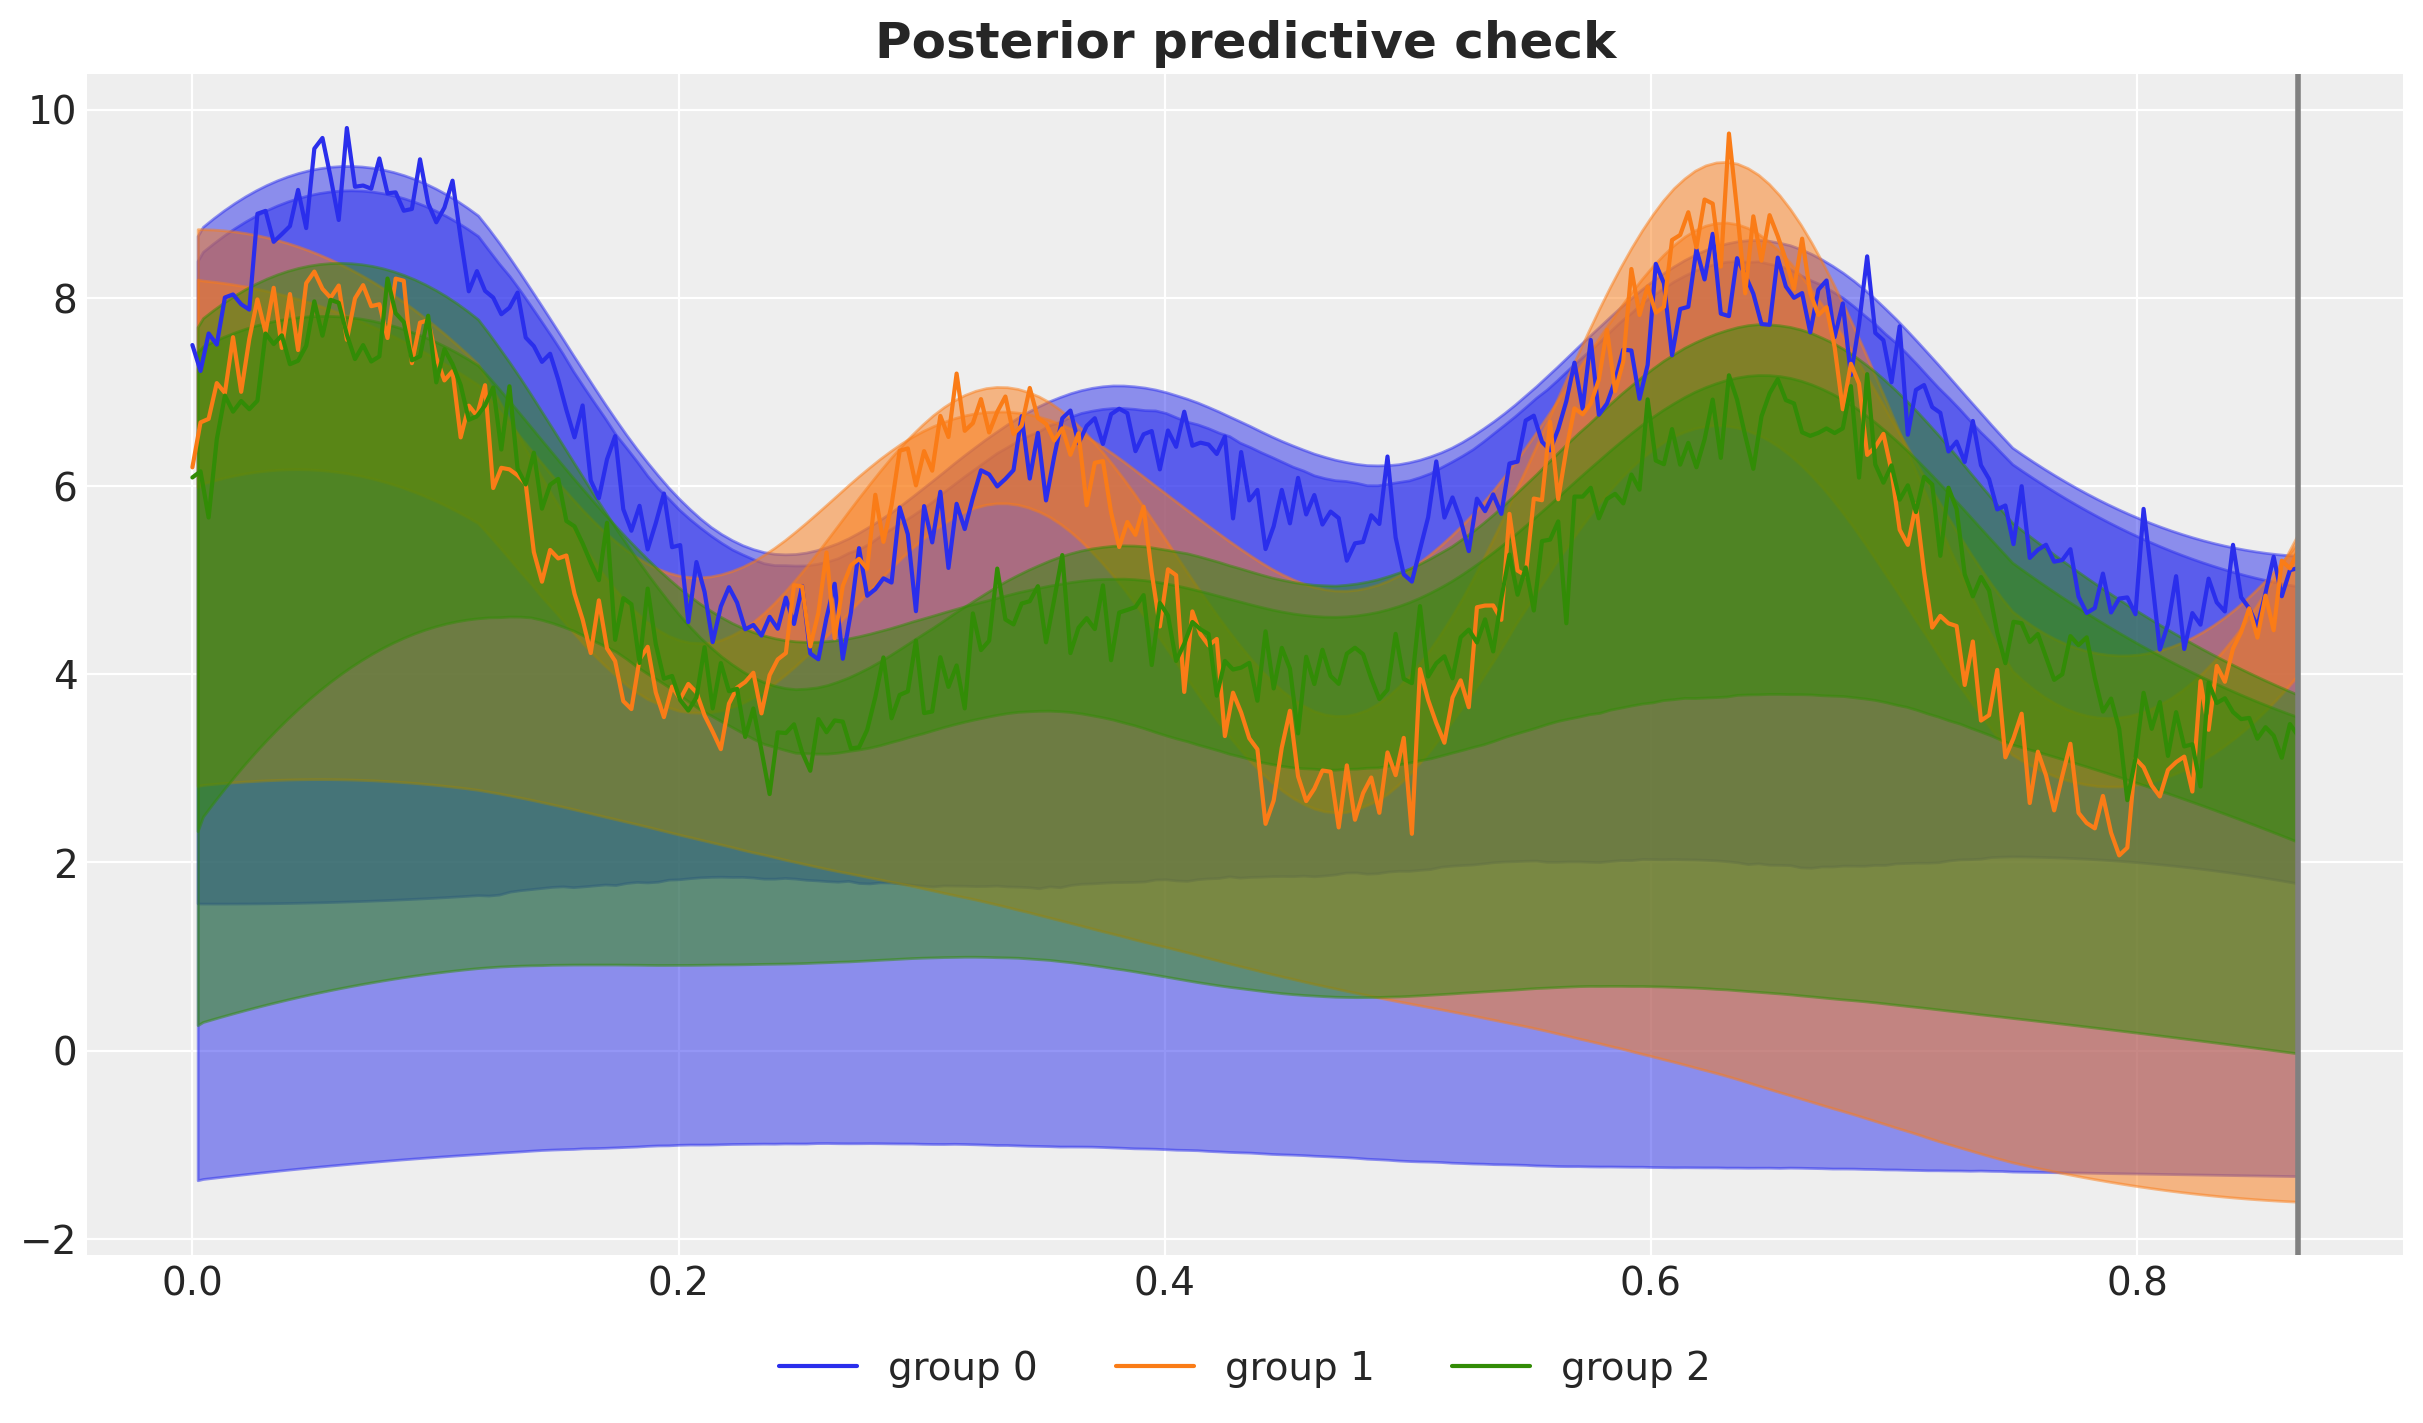

In [60]:
fig, ax = plt.subplots()


for group in range(n_groups):
    for hdi_prob in [0.5, 0.94]:
        az.plot_hdi(
            x_train,
            idata["posterior_predictive"]["obs"].sel(group=group),
            fill_kwargs={"color": f"C{group}", "alpha": 0.5},
            ax=ax,
            hdi_prob=hdi_prob,
        )

for g in range(n_groups):
    ax.plot(x_train, y_train[g], c=f"C{g}", label=f"group {g}")

ax.axvline(x=x_train[-1], c="gray", lw=2)
ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=n_groups)
ax.set_title("Posterior predictive check", fontsize=18, fontweight="bold");

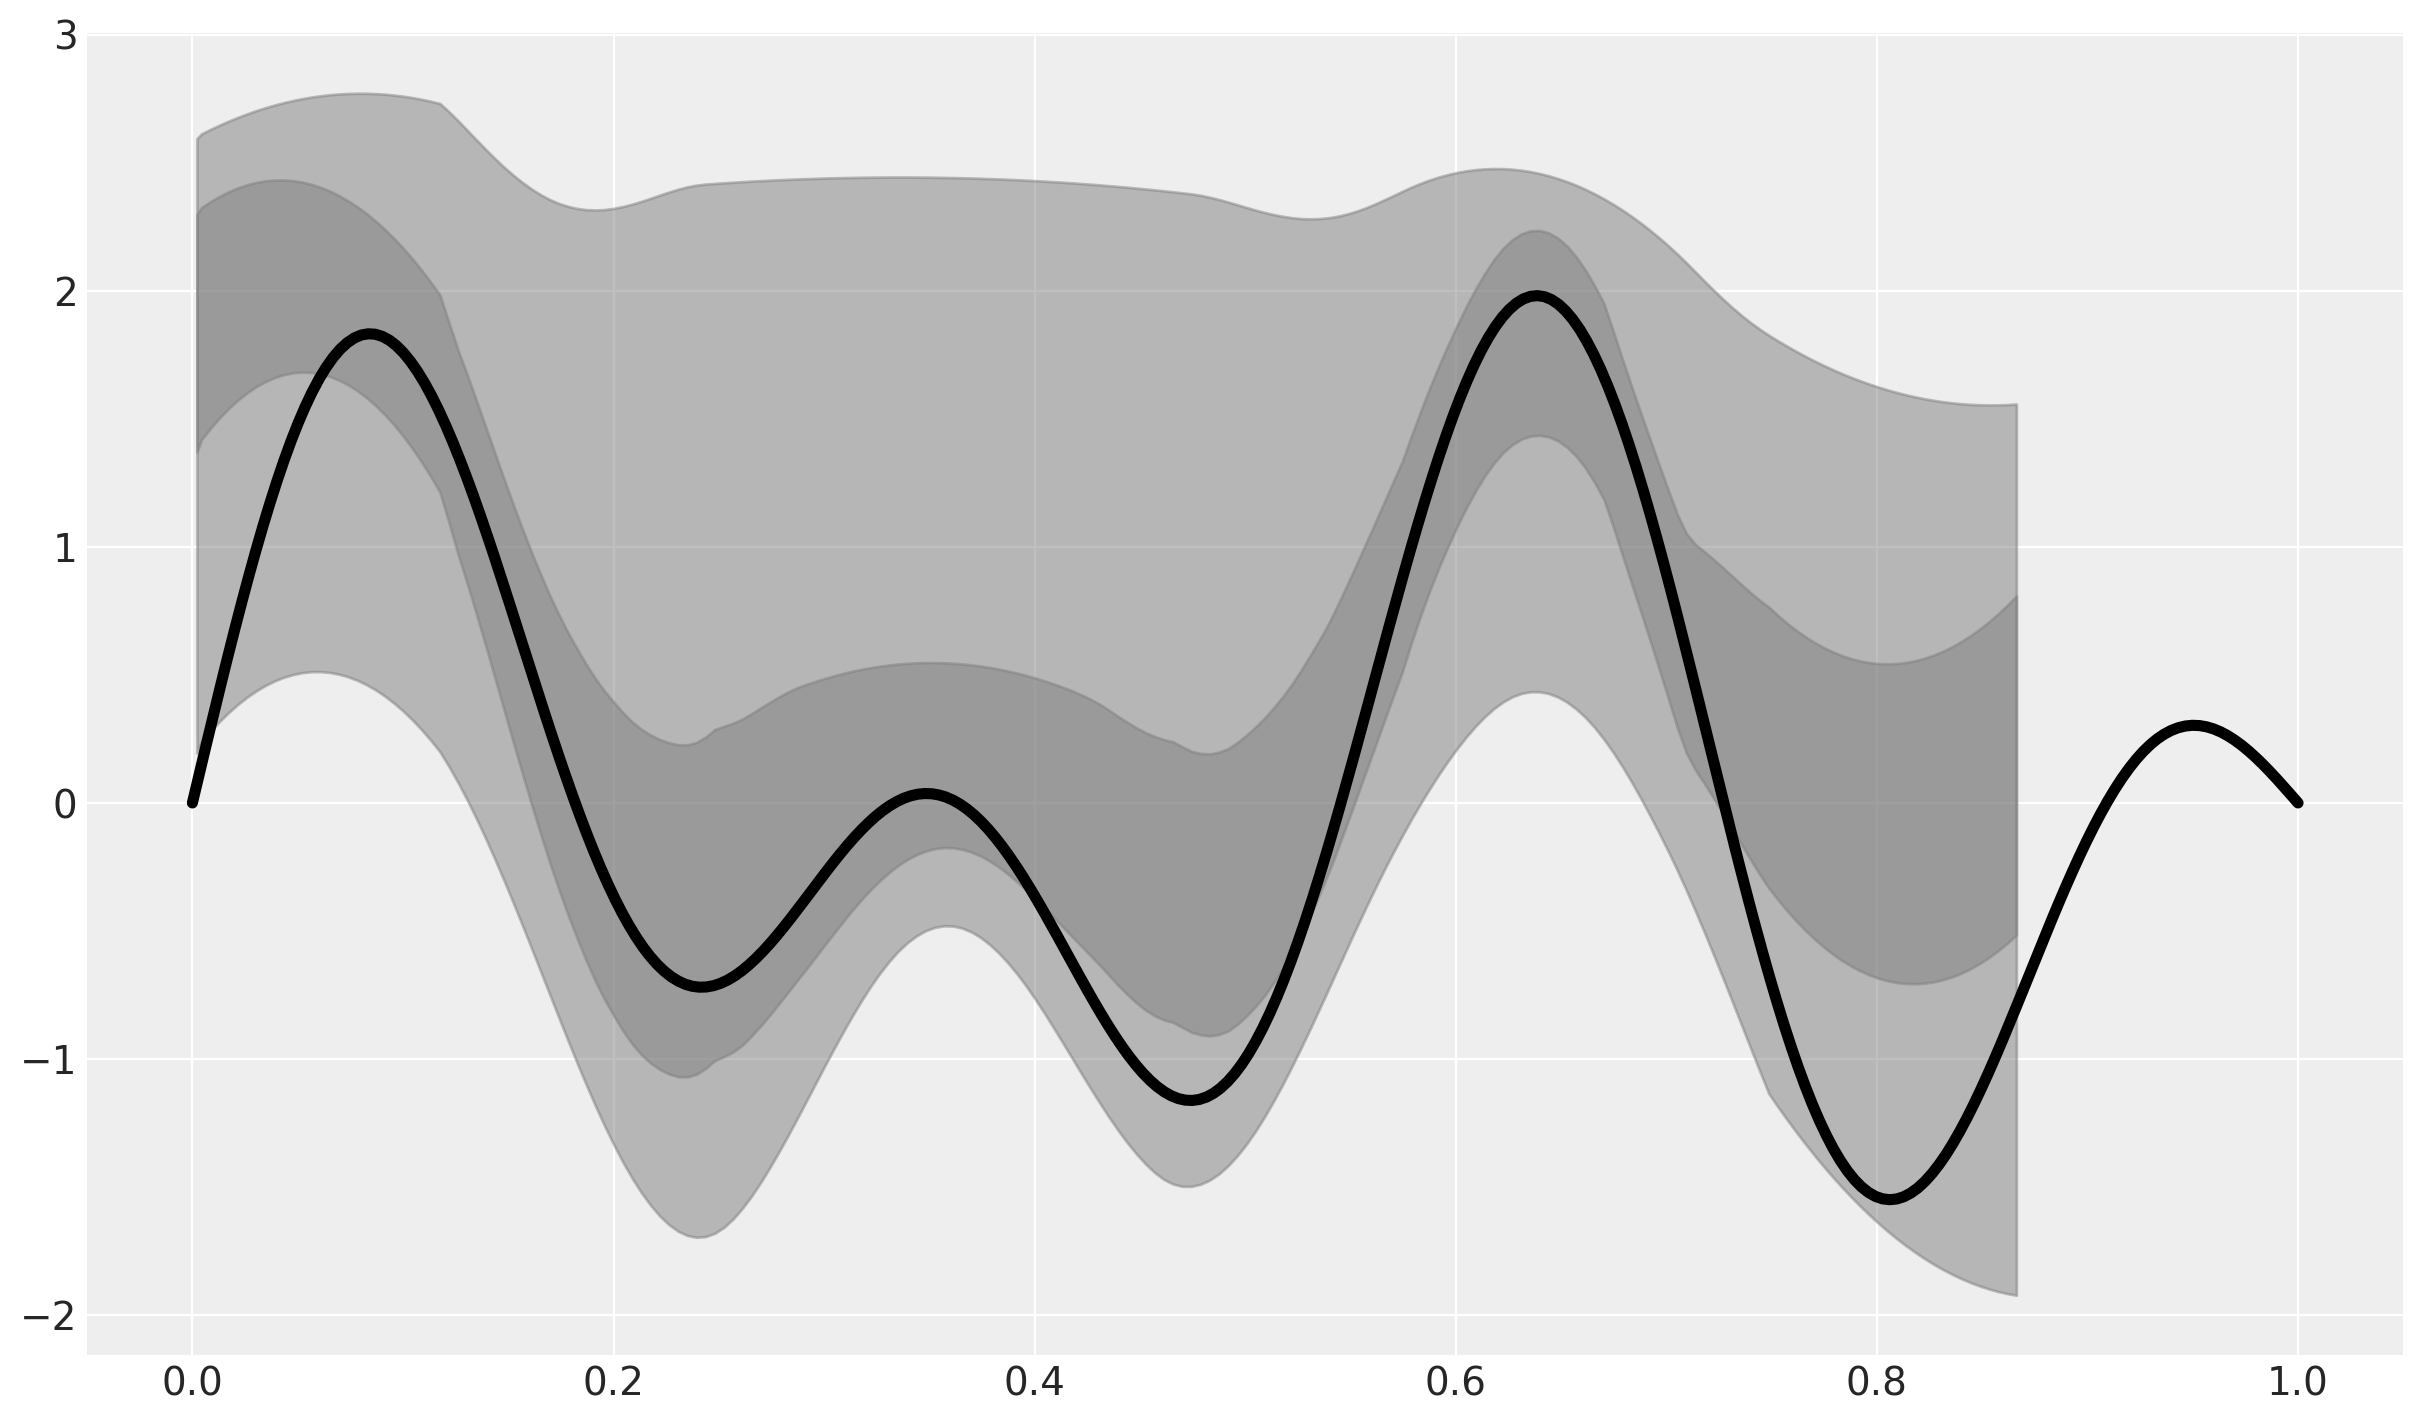

In [61]:
fig, ax = plt.subplots()
for hdi_prob in [0.5, 0.94]:
    az.plot_hdi(
        x_train,
        idata["posterior"]["f_global"],
        fill_kwargs={"color": "gray", "alpha": 0.5},
        ax=ax,
        hdi_prob=hdi_prob,
    )
ax.plot(x, f[0], c="black", lw=4, label="Mean function")

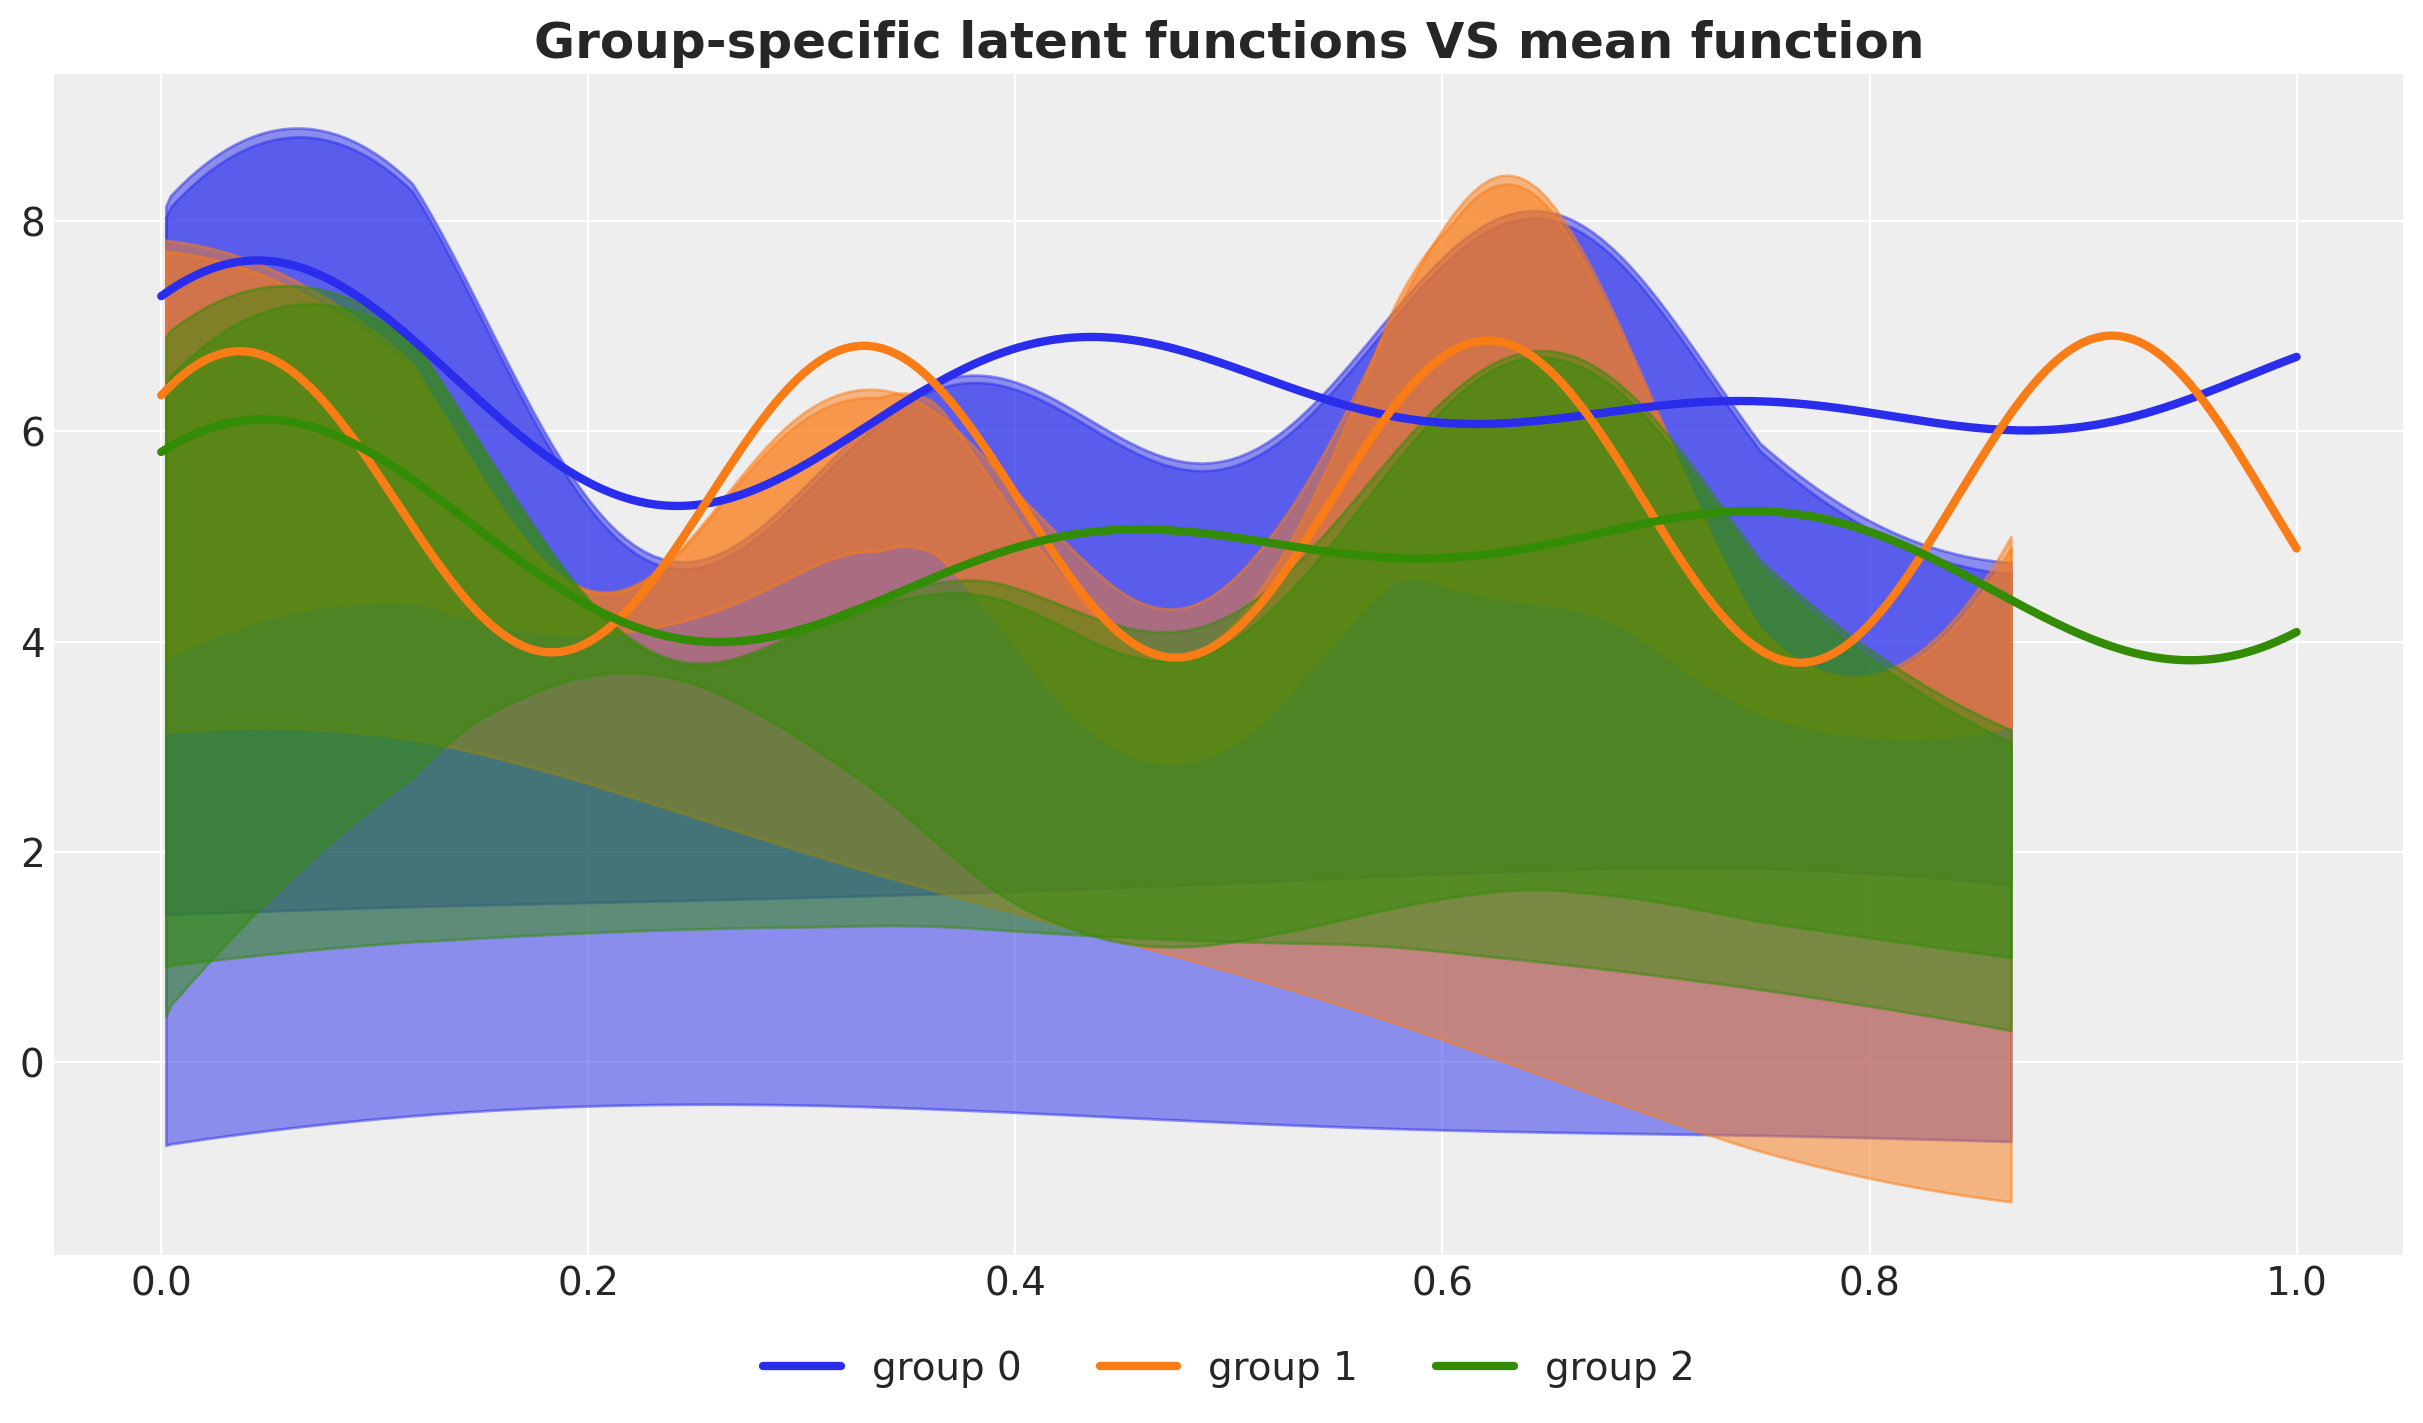

In [62]:
fig, ax = plt.subplots()

for group in range(n_groups):
    for hdi_prob in [0.5, 0.94]:
        az.plot_hdi(
            x_train,
            idata["posterior"]["f_group"].sel(group=group),
            fill_kwargs={"color": f"C{group}", "alpha": 0.5},
            ax=ax,
            hdi_prob=hdi_prob,
        )

for g in range(n_groups):
    ax.plot(x, f_g[g], lw=3, c=f"C{g}", label=f"group {g}")

ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=n_groups + 1)
ax.set_title(
    "Group-specific latent functions VS mean function", fontsize=18, fontweight="bold"
);

/var/folders/p5/ndc9d2b90_x9vnt8nzzygcb00000gp/T/ipykernel_2646/2967122753.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=n_groups + 1)


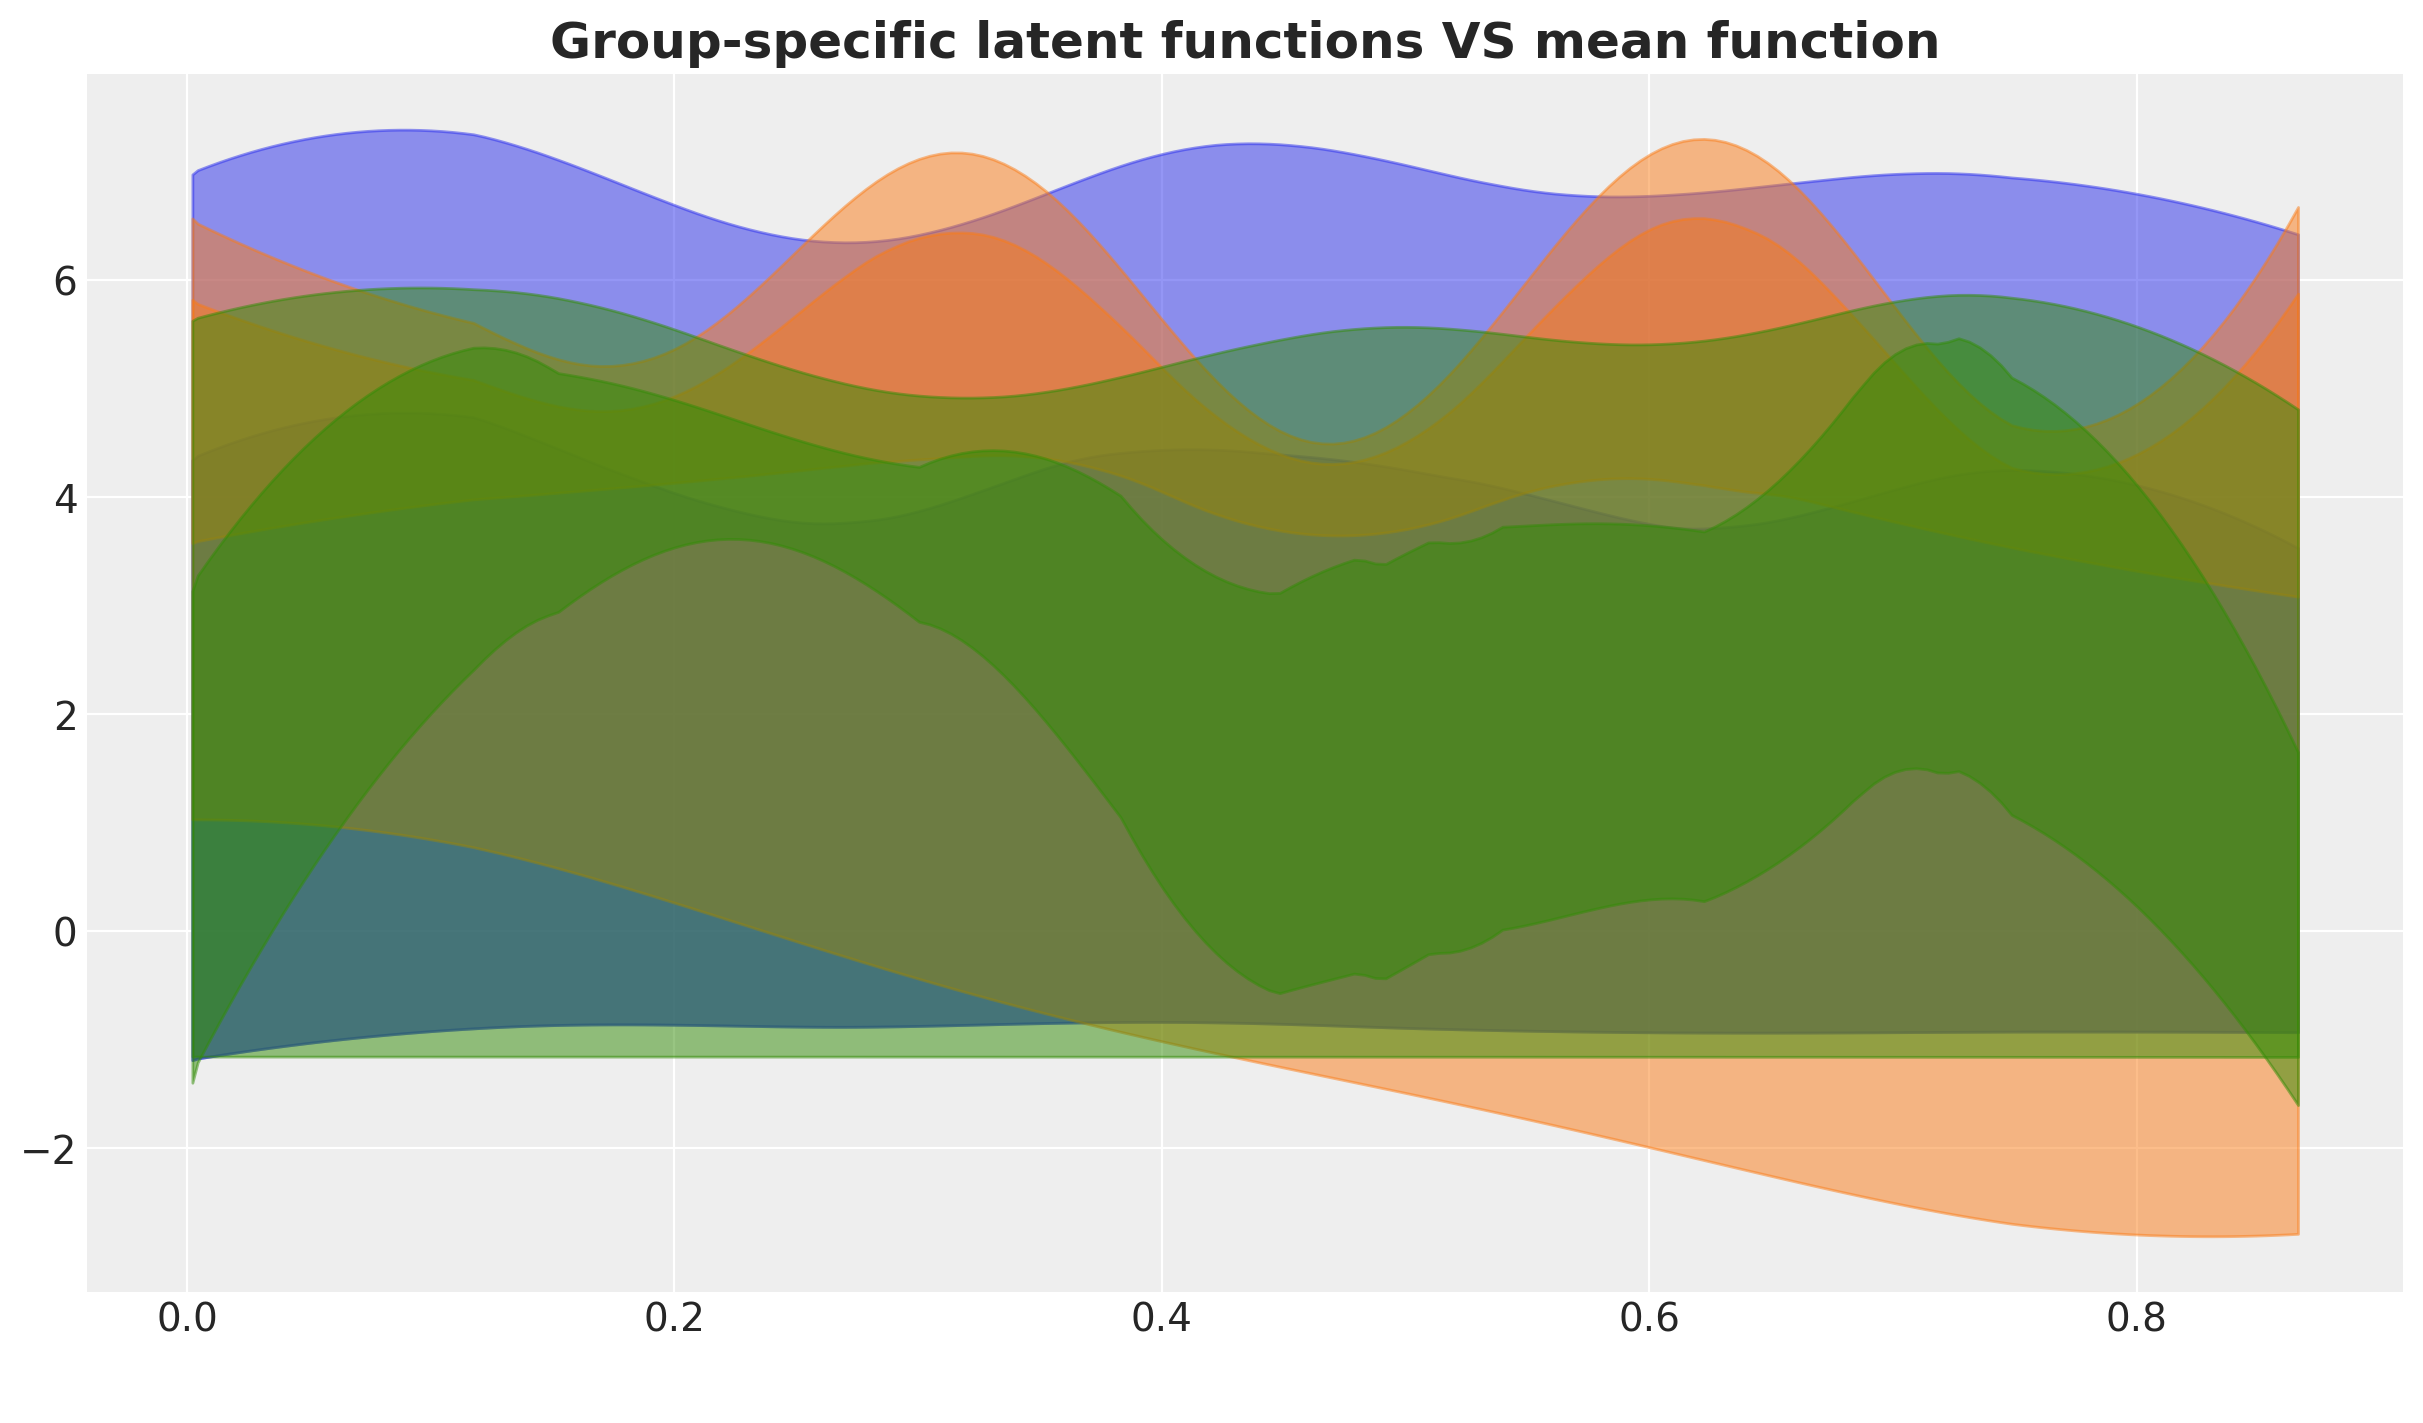

In [63]:
fig, ax = plt.subplots()

for group in range(n_groups):
    for hdi_prob in [0.5, 0.94]:
        az.plot_hdi(
            x_train,
            idata["posterior"]["f_delta"].sel(group=group),
            fill_kwargs={"color": f"C{group}", "alpha": 0.5},
            ax=ax,
            hdi_prob=hdi_prob,
        )


ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=n_groups + 1)
ax.set_title(
    "Group-specific latent functions VS mean function", fontsize=18, fontweight="bold"
);